<a href="https://colab.research.google.com/github/andreas31603/MachineLearningTasks/blob/main/Task12/CNNFashion_mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
# Transformasi data untuk normalisasi input
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Periksa apakah CUDA tersedia untuk menjalankan model di GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Memuat dataset FashionMNIST untuk data pelatihan dan pengujian
train_dataset = datasets.FashionMNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.FashionMNIST(root='./data', train=False, transform=transform, download=True)

# Membagi data pelatihan menjadi pelatihan dan validasi
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

# Membuat DataLoader untuk pelatihan, validasi, dan pengujian
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Using device: cuda


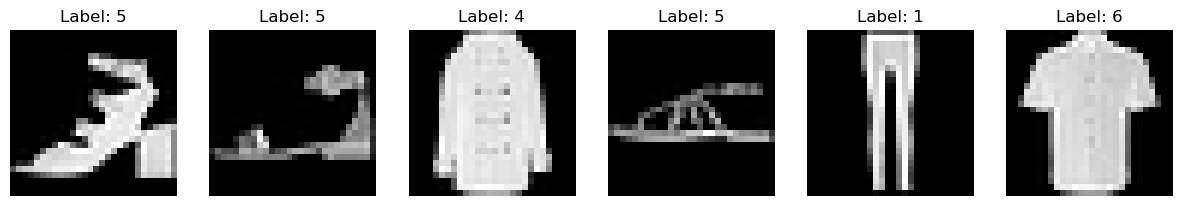

In [ ]:
# Menampilkan beberapa sampel dari dataset pelatihan
import matplotlib.pyplot as plt

examples = iter(train_loader)
example_data, example_labels = next(examples)

fig, axes = plt.subplots(1, 6, figsize=(15, 5))
for i in range(6):
    axes[i].imshow(example_data[i][0], cmap='gray')
    axes[i].set_title(f"Label: {example_labels[i].item()}")
    axes[i].axis('off')
plt.savefig("Task12CNN/train_dataset_samples.png")
plt.show()

In [ ]:
# Definisi model CNN dengan parameter kernel_size dan pooling_type
class CNNModel(nn.Module):
    def __init__(self, kernel_size, pooling_type):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=kernel_size, padding=kernel_size // 2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=kernel_size, padding=kernel_size // 2)
        self.pool = nn.MaxPool2d(2) if pooling_type == 'max' else nn.AvgPool2d(2)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = self.pool(x)
        x = torch.relu(self.conv2(x))
        x = self.pool(x)
        x = x.view(-1, 64 * 7 * 7)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x


In [ ]:
# Fungsi untuk melatih model
def train_model(model, optimizer, scheduler, criterion, train_loader, val_loader, epochs):
    model.to(device)
    best_val_loss = float('inf')
    early_stop_counter = 0
    history = {'train_loss': [], 'val_loss': []}

    for epoch in range(epochs):
        model.train()
        train_loss = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        train_loss /= len(train_loader)
        history['train_loss'].append(train_loss)

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

        val_loss /= len(val_loader)
        history['val_loss'].append(val_loss)
        scheduler.step(val_loss)

        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            early_stop_counter = 0
        else:
            early_stop_counter += 1

        if early_stop_counter >= 10:
            print("Early stopping triggered.")
            break

    return history

In [ ]:
# Fungsi untuk menguji model pada dataset pengujian
def test_model(model, test_loader):
    model.to(device)
    model.eval()
    all_preds, all_labels = [], []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    print(f"Test Accuracy: {accuracy * 100:.2f}%")


In [ ]:
# Eksperimen hyperparameter dengan berbagai kombinasi kernel, pooling, dan optimizer
kernels = [3, 5, 7]
poolings = ['max', 'avg']
epochs_list = [5, 50, 100, 250, 350]  # Menyesuaikan jumlah epoch
optimizers = [optim.SGD, optim.RMSprop, optim.Adam]

final_results = []

for kernel in kernels:
    for pooling in poolings:
        for optimizer_func in optimizers:
            for epochs in epochs_list:
                print(f"Running for Kernel: {kernel}, Pooling: {pooling}, Optimizer: {optimizer_func.__name__}, Epochs: {epochs}")

                model = CNNModel(kernel_size=kernel, pooling_type=pooling)
                optimizer = optimizer_func(model.parameters(), lr=0.01)
                scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=5, verbose=True)
                criterion = nn.CrossEntropyLoss()

                history = train_model(model, optimizer, scheduler, criterion, train_loader, val_loader, epochs)
                test_model(model, test_loader)

                # Plot Loss
                plt.plot(history['train_loss'], label='Train Loss')
                plt.plot(history['val_loss'], label='Validation Loss')
                plt.title(f"Kernel: {kernel}, Pooling: {pooling}, Optimizer: {optimizer_func.__name__}, Epochs: {epochs}")
                plt.xlabel("Epoch")
                plt.ylabel("Loss")
                plt.legend()
                plt.savefig(f"Task12CNN/loss_kernel{kernel}_pooling{pooling}_optimizer{optimizer_func.__name__}_epochs{epochs}.png")
                plt.close()

                # Menyimpan hasil akhir
                final_results.append((kernel, pooling, optimizer_func.__name__, epochs, history['train_loss'][-1], history['val_loss'][-1]))


Running for Kernel: 3, Pooling: max, Optimizer: SGD, Epochs: 5


c:\Users\LENOVO\anaconda3\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/5, Train Loss: 1.0326, Val Loss: 0.5680
Epoch 2/5, Train Loss: 0.5267, Val Loss: 0.4810
Epoch 3/5, Train Loss: 0.4529, Val Loss: 0.4609
Epoch 4/5, Train Loss: 0.4119, Val Loss: 0.4064
Epoch 5/5, Train Loss: 0.3857, Val Loss: 0.3792
Test Accuracy: 85.99%
Running for Kernel: 3, Pooling: max, Optimizer: SGD, Epochs: 50


c:\Users\LENOVO\anaconda3\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/50, Train Loss: 1.0514, Val Loss: 0.6030
Epoch 2/50, Train Loss: 0.5525, Val Loss: 0.5074
Epoch 3/50, Train Loss: 0.4740, Val Loss: 0.4422
Epoch 4/50, Train Loss: 0.4278, Val Loss: 0.4152
Epoch 5/50, Train Loss: 0.3981, Val Loss: 0.4141
Epoch 6/50, Train Loss: 0.3766, Val Loss: 0.3724
Epoch 7/50, Train Loss: 0.3594, Val Loss: 0.3536
Epoch 8/50, Train Loss: 0.3461, Val Loss: 0.3409
Epoch 9/50, Train Loss: 0.3338, Val Loss: 0.3317
Epoch 10/50, Train Loss: 0.3216, Val Loss: 0.3221
Epoch 11/50, Train Loss: 0.3130, Val Loss: 0.3356
Epoch 12/50, Train Loss: 0.3041, Val Loss: 0.3201
Epoch 13/50, Train Loss: 0.2952, Val Loss: 0.3067
Epoch 14/50, Train Loss: 0.2870, Val Loss: 0.3129
Epoch 15/50, Train Loss: 0.2797, Val Loss: 0.2945
Epoch 16/50, Train Loss: 0.2729, Val Loss: 0.2929
Epoch 17/50, Train Loss: 0.2660, Val Loss: 0.2856
Epoch 18/50, Train Loss: 0.2601, Val Loss: 0.2943
Epoch 19/50, Train Loss: 0.2549, Val Loss: 0.2901
Epoch 20/50, Train Loss: 0.2489, Val Loss: 0.2721
Epoch 21/

c:\Users\LENOVO\anaconda3\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/100, Train Loss: 1.0346, Val Loss: 0.5795
Epoch 2/100, Train Loss: 0.5253, Val Loss: 0.4838
Epoch 3/100, Train Loss: 0.4532, Val Loss: 0.4497
Epoch 4/100, Train Loss: 0.4138, Val Loss: 0.4115
Epoch 5/100, Train Loss: 0.3856, Val Loss: 0.3746
Epoch 6/100, Train Loss: 0.3649, Val Loss: 0.3580
Epoch 7/100, Train Loss: 0.3501, Val Loss: 0.3488
Epoch 8/100, Train Loss: 0.3363, Val Loss: 0.3486
Epoch 9/100, Train Loss: 0.3245, Val Loss: 0.3293
Epoch 10/100, Train Loss: 0.3128, Val Loss: 0.3288
Epoch 11/100, Train Loss: 0.3049, Val Loss: 0.3148
Epoch 12/100, Train Loss: 0.2962, Val Loss: 0.3032
Epoch 13/100, Train Loss: 0.2906, Val Loss: 0.3035
Epoch 14/100, Train Loss: 0.2819, Val Loss: 0.2981
Epoch 15/100, Train Loss: 0.2747, Val Loss: 0.3019
Epoch 16/100, Train Loss: 0.2694, Val Loss: 0.2841
Epoch 17/100, Train Loss: 0.2622, Val Loss: 0.2740
Epoch 18/100, Train Loss: 0.2564, Val Loss: 0.2777
Epoch 19/100, Train Loss: 0.2516, Val Loss: 0.2838
Epoch 20/100, Train Loss: 0.2444, Val Lo

c:\Users\LENOVO\anaconda3\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/250, Train Loss: 0.9699, Val Loss: 0.6617
Epoch 2/250, Train Loss: 0.5795, Val Loss: 0.5457
Epoch 3/250, Train Loss: 0.5025, Val Loss: 0.4850
Epoch 4/250, Train Loss: 0.4484, Val Loss: 0.5228
Epoch 5/250, Train Loss: 0.4150, Val Loss: 0.4062
Epoch 6/250, Train Loss: 0.3889, Val Loss: 0.4049
Epoch 7/250, Train Loss: 0.3678, Val Loss: 0.3596
Epoch 8/250, Train Loss: 0.3516, Val Loss: 0.3547
Epoch 9/250, Train Loss: 0.3382, Val Loss: 0.3430
Epoch 10/250, Train Loss: 0.3261, Val Loss: 0.3459
Epoch 11/250, Train Loss: 0.3158, Val Loss: 0.3200
Epoch 12/250, Train Loss: 0.3056, Val Loss: 0.3145
Epoch 13/250, Train Loss: 0.2966, Val Loss: 0.3042
Epoch 14/250, Train Loss: 0.2877, Val Loss: 0.3009
Epoch 15/250, Train Loss: 0.2801, Val Loss: 0.2909
Epoch 16/250, Train Loss: 0.2735, Val Loss: 0.2934
Epoch 17/250, Train Loss: 0.2671, Val Loss: 0.2828
Epoch 18/250, Train Loss: 0.2619, Val Loss: 0.2838
Epoch 19/250, Train Loss: 0.2562, Val Loss: 0.2751
Epoch 20/250, Train Loss: 0.2494, Val Lo

c:\Users\LENOVO\anaconda3\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/350, Train Loss: 1.0205, Val Loss: 0.6233
Epoch 2/350, Train Loss: 0.5547, Val Loss: 0.5126
Epoch 3/350, Train Loss: 0.4779, Val Loss: 0.4613
Epoch 4/350, Train Loss: 0.4301, Val Loss: 0.4310
Epoch 5/350, Train Loss: 0.3972, Val Loss: 0.3863
Epoch 6/350, Train Loss: 0.3742, Val Loss: 0.3613
Epoch 7/350, Train Loss: 0.3562, Val Loss: 0.3538
Epoch 8/350, Train Loss: 0.3406, Val Loss: 0.3393
Epoch 9/350, Train Loss: 0.3276, Val Loss: 0.3293
Epoch 10/350, Train Loss: 0.3177, Val Loss: 0.3460
Epoch 11/350, Train Loss: 0.3071, Val Loss: 0.3213
Epoch 12/350, Train Loss: 0.2979, Val Loss: 0.3236
Epoch 13/350, Train Loss: 0.2888, Val Loss: 0.3099
Epoch 14/350, Train Loss: 0.2829, Val Loss: 0.2961
Epoch 15/350, Train Loss: 0.2744, Val Loss: 0.2919
Epoch 16/350, Train Loss: 0.2688, Val Loss: 0.2893
Epoch 17/350, Train Loss: 0.2624, Val Loss: 0.2833
Epoch 18/350, Train Loss: 0.2572, Val Loss: 0.2836
Epoch 19/350, Train Loss: 0.2518, Val Loss: 0.2680
Epoch 20/350, Train Loss: 0.2462, Val Lo

c:\Users\LENOVO\anaconda3\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/5, Train Loss: 2.6683, Val Loss: 0.4964
Epoch 2/5, Train Loss: 0.5731, Val Loss: 0.4797
Epoch 3/5, Train Loss: 0.3996, Val Loss: 0.4156
Epoch 4/5, Train Loss: 0.3667, Val Loss: 0.3564
Epoch 5/5, Train Loss: 0.3434, Val Loss: 0.3736
Test Accuracy: 85.62%
Running for Kernel: 3, Pooling: max, Optimizer: RMSprop, Epochs: 50


c:\Users\LENOVO\anaconda3\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/50, Train Loss: 3.7327, Val Loss: 0.4318
Epoch 2/50, Train Loss: 0.4083, Val Loss: 0.3733
Epoch 3/50, Train Loss: 0.3704, Val Loss: 0.3479
Epoch 4/50, Train Loss: 0.3449, Val Loss: 0.3262
Epoch 5/50, Train Loss: 0.3300, Val Loss: 0.3288
Epoch 6/50, Train Loss: 0.3182, Val Loss: 0.3422
Epoch 7/50, Train Loss: 0.3053, Val Loss: 0.3316
Epoch 8/50, Train Loss: 0.3016, Val Loss: 0.3163
Epoch 9/50, Train Loss: 0.2937, Val Loss: 0.3655
Epoch 10/50, Train Loss: 0.2911, Val Loss: 0.3295
Epoch 11/50, Train Loss: 0.2845, Val Loss: 0.3308
Epoch 12/50, Train Loss: 0.2814, Val Loss: 0.3305
Epoch 13/50, Train Loss: 0.2772, Val Loss: 0.3282
Epoch 14/50, Train Loss: 0.2730, Val Loss: 0.3397
Epoch 15/50, Train Loss: 0.2041, Val Loss: 0.3022
Epoch 16/50, Train Loss: 0.1865, Val Loss: 0.3069
Epoch 17/50, Train Loss: 0.1794, Val Loss: 0.3036
Epoch 18/50, Train Loss: 0.1730, Val Loss: 0.3071
Epoch 19/50, Train Loss: 0.1694, Val Loss: 0.3061
Epoch 20/50, Train Loss: 0.1653, Val Loss: 0.3218
Epoch 21/

c:\Users\LENOVO\anaconda3\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/100, Train Loss: 3.7377, Val Loss: 0.4040
Epoch 2/100, Train Loss: 0.4993, Val Loss: 0.3561
Epoch 3/100, Train Loss: 0.3546, Val Loss: 0.3427
Epoch 4/100, Train Loss: 0.3220, Val Loss: 0.3792
Epoch 5/100, Train Loss: 0.3088, Val Loss: 0.3599
Epoch 6/100, Train Loss: 0.2938, Val Loss: 0.3473
Epoch 7/100, Train Loss: 0.2845, Val Loss: 0.3208
Epoch 8/100, Train Loss: 0.2819, Val Loss: 0.3248
Epoch 9/100, Train Loss: 0.2692, Val Loss: 0.3773
Epoch 10/100, Train Loss: 0.2794, Val Loss: 0.3948
Epoch 11/100, Train Loss: 0.2632, Val Loss: 0.4331
Epoch 12/100, Train Loss: 0.2816, Val Loss: 0.3901
Epoch 13/100, Train Loss: 0.2609, Val Loss: 0.3697
Epoch 14/100, Train Loss: 0.1889, Val Loss: 0.3297
Epoch 15/100, Train Loss: 0.1687, Val Loss: 0.3383
Epoch 16/100, Train Loss: 0.1594, Val Loss: 0.3449
Epoch 17/100, Train Loss: 0.1525, Val Loss: 0.3512
Early stopping triggered.
Test Accuracy: 90.05%
Running for Kernel: 3, Pooling: max, Optimizer: RMSprop, Epochs: 250


c:\Users\LENOVO\anaconda3\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/250, Train Loss: 2.4948, Val Loss: 0.4698
Epoch 2/250, Train Loss: 0.4150, Val Loss: 0.3660
Epoch 3/250, Train Loss: 0.3633, Val Loss: 0.3763
Epoch 4/250, Train Loss: 0.3326, Val Loss: 0.3528
Epoch 5/250, Train Loss: 0.3125, Val Loss: 0.3582
Epoch 6/250, Train Loss: 0.3053, Val Loss: 0.3183
Epoch 7/250, Train Loss: 0.2933, Val Loss: 0.3246
Epoch 8/250, Train Loss: 0.2836, Val Loss: 0.3125
Epoch 9/250, Train Loss: 0.2802, Val Loss: 0.3504
Epoch 10/250, Train Loss: 0.2792, Val Loss: 0.3289
Epoch 11/250, Train Loss: 0.2693, Val Loss: 0.3834
Epoch 12/250, Train Loss: 0.2650, Val Loss: 0.3811
Epoch 13/250, Train Loss: 0.2656, Val Loss: 0.3179
Epoch 14/250, Train Loss: 0.2635, Val Loss: 0.3938
Epoch 15/250, Train Loss: 0.1812, Val Loss: 0.3090
Epoch 16/250, Train Loss: 0.1587, Val Loss: 0.3096
Epoch 17/250, Train Loss: 0.1497, Val Loss: 0.3169
Epoch 18/250, Train Loss: 0.1438, Val Loss: 0.3190
Epoch 19/250, Train Loss: 0.1382, Val Loss: 0.3249
Epoch 20/250, Train Loss: 0.1341, Val Lo

c:\Users\LENOVO\anaconda3\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/350, Train Loss: 3.2043, Val Loss: 0.5450
Epoch 2/350, Train Loss: 0.4665, Val Loss: 0.4565
Epoch 3/350, Train Loss: 0.4124, Val Loss: 0.3795
Epoch 4/350, Train Loss: 0.3512, Val Loss: 0.3522
Epoch 5/350, Train Loss: 0.3339, Val Loss: 0.3852
Epoch 6/350, Train Loss: 0.3234, Val Loss: 0.3418
Epoch 7/350, Train Loss: 0.3195, Val Loss: 0.3463
Epoch 8/350, Train Loss: 0.2971, Val Loss: 0.3429
Epoch 9/350, Train Loss: 0.2899, Val Loss: 0.3302
Epoch 10/350, Train Loss: 0.2839, Val Loss: 0.4057
Epoch 11/350, Train Loss: 0.2779, Val Loss: 0.3404
Epoch 12/350, Train Loss: 0.2801, Val Loss: 0.3660
Epoch 13/350, Train Loss: 0.2680, Val Loss: 0.3369
Epoch 14/350, Train Loss: 0.2665, Val Loss: 0.3710
Epoch 15/350, Train Loss: 0.2560, Val Loss: 0.3493
Epoch 16/350, Train Loss: 0.1823, Val Loss: 0.3210
Epoch 17/350, Train Loss: 0.1636, Val Loss: 0.3217
Epoch 18/350, Train Loss: 0.1550, Val Loss: 0.3268
Epoch 19/350, Train Loss: 0.1492, Val Loss: 0.3354
Epoch 20/350, Train Loss: 0.1436, Val Lo

c:\Users\LENOVO\anaconda3\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/5, Train Loss: 0.4796, Val Loss: 0.3486
Epoch 2/5, Train Loss: 0.3356, Val Loss: 0.3342
Epoch 3/5, Train Loss: 0.3160, Val Loss: 0.3845
Epoch 4/5, Train Loss: 0.2958, Val Loss: 0.3682
Epoch 5/5, Train Loss: 0.2856, Val Loss: 0.3172
Test Accuracy: 88.23%
Running for Kernel: 3, Pooling: max, Optimizer: Adam, Epochs: 50


c:\Users\LENOVO\anaconda3\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/50, Train Loss: 0.5367, Val Loss: 0.4007
Epoch 2/50, Train Loss: 0.3942, Val Loss: 0.3630
Epoch 3/50, Train Loss: 0.3711, Val Loss: 0.3873
Epoch 4/50, Train Loss: 0.3491, Val Loss: 0.3704
Epoch 5/50, Train Loss: 0.3415, Val Loss: 0.3714
Epoch 6/50, Train Loss: 0.3296, Val Loss: 0.3604
Epoch 7/50, Train Loss: 0.3220, Val Loss: 0.3618
Epoch 8/50, Train Loss: 0.3197, Val Loss: 0.3599
Epoch 9/50, Train Loss: 0.3144, Val Loss: 0.3374
Epoch 10/50, Train Loss: 0.3114, Val Loss: 0.3637
Epoch 11/50, Train Loss: 0.3062, Val Loss: 0.3486
Epoch 12/50, Train Loss: 0.3043, Val Loss: 0.3813
Epoch 13/50, Train Loss: 0.3041, Val Loss: 0.3824
Epoch 14/50, Train Loss: 0.2981, Val Loss: 0.3538
Epoch 15/50, Train Loss: 0.2982, Val Loss: 0.3700
Epoch 16/50, Train Loss: 0.2434, Val Loss: 0.3201
Epoch 17/50, Train Loss: 0.2247, Val Loss: 0.3145
Epoch 18/50, Train Loss: 0.2174, Val Loss: 0.3159
Epoch 19/50, Train Loss: 0.2121, Val Loss: 0.3136
Epoch 20/50, Train Loss: 0.2086, Val Loss: 0.3248
Epoch 21/

c:\Users\LENOVO\anaconda3\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/100, Train Loss: 0.5315, Val Loss: 0.4150
Epoch 2/100, Train Loss: 0.3679, Val Loss: 0.3635
Epoch 3/100, Train Loss: 0.3373, Val Loss: 0.3456
Epoch 4/100, Train Loss: 0.3244, Val Loss: 0.3372
Epoch 5/100, Train Loss: 0.3123, Val Loss: 0.3472
Epoch 6/100, Train Loss: 0.3094, Val Loss: 0.3414
Epoch 7/100, Train Loss: 0.3062, Val Loss: 0.3747
Epoch 8/100, Train Loss: 0.2971, Val Loss: 0.3219
Epoch 9/100, Train Loss: 0.2988, Val Loss: 0.3455
Epoch 10/100, Train Loss: 0.2888, Val Loss: 0.3403
Epoch 11/100, Train Loss: 0.2873, Val Loss: 0.3425
Epoch 12/100, Train Loss: 0.2835, Val Loss: 0.3479
Epoch 13/100, Train Loss: 0.2807, Val Loss: 0.3521
Epoch 14/100, Train Loss: 0.2791, Val Loss: 0.3520
Epoch 15/100, Train Loss: 0.2216, Val Loss: 0.2972
Epoch 16/100, Train Loss: 0.2056, Val Loss: 0.2947
Epoch 17/100, Train Loss: 0.1995, Val Loss: 0.2982
Epoch 18/100, Train Loss: 0.1939, Val Loss: 0.2914
Epoch 19/100, Train Loss: 0.1899, Val Loss: 0.2943
Epoch 20/100, Train Loss: 0.1860, Val Lo

c:\Users\LENOVO\anaconda3\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/250, Train Loss: 0.5275, Val Loss: 0.3896
Epoch 2/250, Train Loss: 0.3696, Val Loss: 0.3638
Epoch 3/250, Train Loss: 0.3489, Val Loss: 0.3550
Epoch 4/250, Train Loss: 0.3321, Val Loss: 0.3367
Epoch 5/250, Train Loss: 0.3238, Val Loss: 0.3574
Epoch 6/250, Train Loss: 0.3165, Val Loss: 0.3257
Epoch 7/250, Train Loss: 0.3090, Val Loss: 0.3734
Epoch 8/250, Train Loss: 0.3049, Val Loss: 0.3381
Epoch 9/250, Train Loss: 0.3033, Val Loss: 0.3537
Epoch 10/250, Train Loss: 0.2918, Val Loss: 0.3487
Epoch 11/250, Train Loss: 0.2901, Val Loss: 0.3458
Epoch 12/250, Train Loss: 0.2878, Val Loss: 0.3459
Epoch 13/250, Train Loss: 0.2307, Val Loss: 0.2878
Epoch 14/250, Train Loss: 0.2116, Val Loss: 0.2846
Epoch 15/250, Train Loss: 0.2030, Val Loss: 0.2899
Epoch 16/250, Train Loss: 0.1980, Val Loss: 0.2886
Epoch 17/250, Train Loss: 0.1936, Val Loss: 0.2925
Epoch 18/250, Train Loss: 0.1904, Val Loss: 0.2941
Epoch 19/250, Train Loss: 0.1858, Val Loss: 0.2916
Epoch 20/250, Train Loss: 0.1835, Val Lo

c:\Users\LENOVO\anaconda3\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/350, Train Loss: 0.6328, Val Loss: 0.4692
Epoch 2/350, Train Loss: 0.4547, Val Loss: 0.4487
Epoch 3/350, Train Loss: 0.4221, Val Loss: 0.4109
Epoch 4/350, Train Loss: 0.4089, Val Loss: 0.4189
Epoch 5/350, Train Loss: 0.3945, Val Loss: 0.4105
Epoch 6/350, Train Loss: 0.3932, Val Loss: 0.4044
Epoch 7/350, Train Loss: 0.3863, Val Loss: 0.3880
Epoch 8/350, Train Loss: 0.3801, Val Loss: 0.4039
Epoch 9/350, Train Loss: 0.3813, Val Loss: 0.3931
Epoch 10/350, Train Loss: 0.3773, Val Loss: 0.3992
Epoch 11/350, Train Loss: 0.3726, Val Loss: 0.3821
Epoch 12/350, Train Loss: 0.3732, Val Loss: 0.4132
Epoch 13/350, Train Loss: 0.3655, Val Loss: 0.3999
Epoch 14/350, Train Loss: 0.3711, Val Loss: 0.4028
Epoch 15/350, Train Loss: 0.3636, Val Loss: 0.4196
Epoch 16/350, Train Loss: 0.3661, Val Loss: 0.3949
Epoch 17/350, Train Loss: 0.3615, Val Loss: 0.3907
Epoch 18/350, Train Loss: 0.3054, Val Loss: 0.3404
Epoch 19/350, Train Loss: 0.2938, Val Loss: 0.3352
Epoch 20/350, Train Loss: 0.2880, Val Lo

c:\Users\LENOVO\anaconda3\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/5, Train Loss: 1.0474, Val Loss: 0.6566
Epoch 2/5, Train Loss: 0.6359, Val Loss: 0.6055
Epoch 3/5, Train Loss: 0.5770, Val Loss: 0.5453
Epoch 4/5, Train Loss: 0.5366, Val Loss: 0.5671
Epoch 5/5, Train Loss: 0.5057, Val Loss: 0.5081
Test Accuracy: 80.78%
Running for Kernel: 3, Pooling: avg, Optimizer: SGD, Epochs: 50


c:\Users\LENOVO\anaconda3\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/50, Train Loss: 1.0818, Val Loss: 0.6743
Epoch 2/50, Train Loss: 0.6346, Val Loss: 0.6130
Epoch 3/50, Train Loss: 0.5764, Val Loss: 0.5537
Epoch 4/50, Train Loss: 0.5352, Val Loss: 0.5204
Epoch 5/50, Train Loss: 0.5046, Val Loss: 0.5756
Epoch 6/50, Train Loss: 0.4798, Val Loss: 0.5179
Epoch 7/50, Train Loss: 0.4580, Val Loss: 0.4656
Epoch 8/50, Train Loss: 0.4395, Val Loss: 0.4271
Epoch 9/50, Train Loss: 0.4275, Val Loss: 0.4251
Epoch 10/50, Train Loss: 0.4153, Val Loss: 0.4093
Epoch 11/50, Train Loss: 0.4028, Val Loss: 0.4051
Epoch 12/50, Train Loss: 0.3943, Val Loss: 0.4009
Epoch 13/50, Train Loss: 0.3855, Val Loss: 0.4062
Epoch 14/50, Train Loss: 0.3761, Val Loss: 0.3754
Epoch 15/50, Train Loss: 0.3689, Val Loss: 0.3719
Epoch 16/50, Train Loss: 0.3643, Val Loss: 0.4000
Epoch 17/50, Train Loss: 0.3581, Val Loss: 0.3689
Epoch 18/50, Train Loss: 0.3511, Val Loss: 0.3571
Epoch 19/50, Train Loss: 0.3445, Val Loss: 0.3759
Epoch 20/50, Train Loss: 0.3411, Val Loss: 0.3484
Epoch 21/

c:\Users\LENOVO\anaconda3\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/100, Train Loss: 1.0630, Val Loss: 0.6538
Epoch 2/100, Train Loss: 0.6255, Val Loss: 0.5925
Epoch 3/100, Train Loss: 0.5711, Val Loss: 0.5501
Epoch 4/100, Train Loss: 0.5344, Val Loss: 0.5500
Epoch 5/100, Train Loss: 0.5037, Val Loss: 0.4858
Epoch 6/100, Train Loss: 0.4784, Val Loss: 0.4597
Epoch 7/100, Train Loss: 0.4584, Val Loss: 0.4572
Epoch 8/100, Train Loss: 0.4421, Val Loss: 0.4551
Epoch 9/100, Train Loss: 0.4266, Val Loss: 0.4191
Epoch 10/100, Train Loss: 0.4138, Val Loss: 0.4272
Epoch 11/100, Train Loss: 0.4016, Val Loss: 0.4047
Epoch 12/100, Train Loss: 0.3923, Val Loss: 0.4134
Epoch 13/100, Train Loss: 0.3828, Val Loss: 0.4109
Epoch 14/100, Train Loss: 0.3742, Val Loss: 0.3868
Epoch 15/100, Train Loss: 0.3653, Val Loss: 0.3756
Epoch 16/100, Train Loss: 0.3585, Val Loss: 0.3653
Epoch 17/100, Train Loss: 0.3523, Val Loss: 0.3514
Epoch 18/100, Train Loss: 0.3448, Val Loss: 0.3509
Epoch 19/100, Train Loss: 0.3403, Val Loss: 0.3473
Epoch 20/100, Train Loss: 0.3333, Val Lo

c:\Users\LENOVO\anaconda3\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/250, Train Loss: 1.1288, Val Loss: 0.7212
Epoch 2/250, Train Loss: 0.6449, Val Loss: 0.6817
Epoch 3/250, Train Loss: 0.5860, Val Loss: 0.5548
Epoch 4/250, Train Loss: 0.5442, Val Loss: 0.5169
Epoch 5/250, Train Loss: 0.5130, Val Loss: 0.5124
Epoch 6/250, Train Loss: 0.4876, Val Loss: 0.4923
Epoch 7/250, Train Loss: 0.4640, Val Loss: 0.4881
Epoch 8/250, Train Loss: 0.4465, Val Loss: 0.4396
Epoch 9/250, Train Loss: 0.4304, Val Loss: 0.4210
Epoch 10/250, Train Loss: 0.4175, Val Loss: 0.4171
Epoch 11/250, Train Loss: 0.4054, Val Loss: 0.4143
Epoch 12/250, Train Loss: 0.3948, Val Loss: 0.4200
Epoch 13/250, Train Loss: 0.3844, Val Loss: 0.3956
Epoch 14/250, Train Loss: 0.3744, Val Loss: 0.3785
Epoch 15/250, Train Loss: 0.3677, Val Loss: 0.3751
Epoch 16/250, Train Loss: 0.3592, Val Loss: 0.3584
Epoch 17/250, Train Loss: 0.3524, Val Loss: 0.3727
Epoch 18/250, Train Loss: 0.3457, Val Loss: 0.3707
Epoch 19/250, Train Loss: 0.3409, Val Loss: 0.3551
Epoch 20/250, Train Loss: 0.3341, Val Lo

c:\Users\LENOVO\anaconda3\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/350, Train Loss: 1.0133, Val Loss: 0.6511
Epoch 2/350, Train Loss: 0.6292, Val Loss: 0.6200
Epoch 3/350, Train Loss: 0.5664, Val Loss: 0.5376
Epoch 4/350, Train Loss: 0.5288, Val Loss: 0.5261
Epoch 5/350, Train Loss: 0.4966, Val Loss: 0.4983
Epoch 6/350, Train Loss: 0.4712, Val Loss: 0.4692
Epoch 7/350, Train Loss: 0.4521, Val Loss: 0.4703
Epoch 8/350, Train Loss: 0.4341, Val Loss: 0.4341
Epoch 9/350, Train Loss: 0.4210, Val Loss: 0.4149
Epoch 10/350, Train Loss: 0.4073, Val Loss: 0.4158
Epoch 11/350, Train Loss: 0.3958, Val Loss: 0.3965
Epoch 12/350, Train Loss: 0.3870, Val Loss: 0.3868
Epoch 13/350, Train Loss: 0.3766, Val Loss: 0.3886
Epoch 14/350, Train Loss: 0.3686, Val Loss: 0.4020
Epoch 15/350, Train Loss: 0.3621, Val Loss: 0.3620
Epoch 16/350, Train Loss: 0.3542, Val Loss: 0.3860
Epoch 17/350, Train Loss: 0.3484, Val Loss: 0.3491
Epoch 18/350, Train Loss: 0.3415, Val Loss: 0.3604
Epoch 19/350, Train Loss: 0.3356, Val Loss: 0.3830
Epoch 20/350, Train Loss: 0.3303, Val Lo

c:\Users\LENOVO\anaconda3\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/5, Train Loss: 2.6365, Val Loss: 0.4504
Epoch 2/5, Train Loss: 0.4740, Val Loss: 0.3772
Epoch 3/5, Train Loss: 0.3552, Val Loss: 0.3670
Epoch 4/5, Train Loss: 0.3181, Val Loss: 0.3529
Epoch 5/5, Train Loss: 0.3096, Val Loss: 0.3131
Test Accuracy: 87.88%
Running for Kernel: 3, Pooling: avg, Optimizer: RMSprop, Epochs: 50


c:\Users\LENOVO\anaconda3\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/50, Train Loss: 3.6434, Val Loss: 0.4422
Epoch 2/50, Train Loss: 0.4535, Val Loss: 0.3483
Epoch 3/50, Train Loss: 0.3397, Val Loss: 0.4199
Epoch 4/50, Train Loss: 0.3159, Val Loss: 0.3287
Epoch 5/50, Train Loss: 0.2806, Val Loss: 0.3295
Epoch 6/50, Train Loss: 0.2631, Val Loss: 0.2848
Epoch 7/50, Train Loss: 0.2530, Val Loss: 0.3000
Epoch 8/50, Train Loss: 0.2345, Val Loss: 0.2954
Epoch 9/50, Train Loss: 0.2212, Val Loss: 0.3217
Epoch 10/50, Train Loss: 0.2176, Val Loss: 0.3237
Epoch 11/50, Train Loss: 0.2099, Val Loss: 0.3249
Epoch 12/50, Train Loss: 0.1987, Val Loss: 0.2969
Epoch 13/50, Train Loss: 0.1359, Val Loss: 0.2923
Epoch 14/50, Train Loss: 0.1240, Val Loss: 0.2973
Epoch 15/50, Train Loss: 0.1172, Val Loss: 0.3102
Epoch 16/50, Train Loss: 0.1128, Val Loss: 0.3165
Early stopping triggered.
Test Accuracy: 91.46%
Running for Kernel: 3, Pooling: avg, Optimizer: RMSprop, Epochs: 100


c:\Users\LENOVO\anaconda3\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/100, Train Loss: 3.1597, Val Loss: 0.4457
Epoch 2/100, Train Loss: 0.4022, Val Loss: 0.3784
Epoch 3/100, Train Loss: 0.3578, Val Loss: 0.3052
Epoch 4/100, Train Loss: 0.3123, Val Loss: 0.3183
Epoch 5/100, Train Loss: 0.2862, Val Loss: 0.3100
Epoch 6/100, Train Loss: 0.2734, Val Loss: 0.2968
Epoch 7/100, Train Loss: 0.2499, Val Loss: 0.2988
Epoch 8/100, Train Loss: 0.2378, Val Loss: 0.2939
Epoch 9/100, Train Loss: 0.2319, Val Loss: 0.3113
Epoch 10/100, Train Loss: 0.2147, Val Loss: 0.2769
Epoch 11/100, Train Loss: 0.2153, Val Loss: 0.2939
Epoch 12/100, Train Loss: 0.2044, Val Loss: 0.3054
Epoch 13/100, Train Loss: 0.1952, Val Loss: 0.3151
Epoch 14/100, Train Loss: 0.1911, Val Loss: 0.3392
Epoch 15/100, Train Loss: 0.1894, Val Loss: 0.3311
Epoch 16/100, Train Loss: 0.2243, Val Loss: 0.3849
Epoch 17/100, Train Loss: 0.1318, Val Loss: 0.3276
Epoch 18/100, Train Loss: 0.1086, Val Loss: 0.3300
Epoch 19/100, Train Loss: 0.0997, Val Loss: 0.3426
Epoch 20/100, Train Loss: 0.0935, Val Lo

c:\Users\LENOVO\anaconda3\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/250, Train Loss: 5.4300, Val Loss: 0.5462
Epoch 2/250, Train Loss: 0.6360, Val Loss: 0.3906
Epoch 3/250, Train Loss: 0.3735, Val Loss: 0.3594
Epoch 4/250, Train Loss: 0.3281, Val Loss: 0.3250
Epoch 5/250, Train Loss: 0.2964, Val Loss: 0.3064
Epoch 6/250, Train Loss: 0.2787, Val Loss: 0.2896
Epoch 7/250, Train Loss: 0.2752, Val Loss: 0.2910
Epoch 8/250, Train Loss: 0.2506, Val Loss: 0.2874
Epoch 9/250, Train Loss: 0.2481, Val Loss: 0.3079
Epoch 10/250, Train Loss: 0.2336, Val Loss: 0.3008
Epoch 11/250, Train Loss: 0.2263, Val Loss: 0.2884
Epoch 12/250, Train Loss: 0.2278, Val Loss: 0.3082
Epoch 13/250, Train Loss: 0.2120, Val Loss: 0.3270
Epoch 14/250, Train Loss: 0.2190, Val Loss: 0.4123
Epoch 15/250, Train Loss: 0.1899, Val Loss: 0.2902
Epoch 16/250, Train Loss: 0.1373, Val Loss: 0.2908
Epoch 17/250, Train Loss: 0.1268, Val Loss: 0.3105
Epoch 18/250, Train Loss: 0.1206, Val Loss: 0.3091
Early stopping triggered.
Test Accuracy: 91.20%
Running for Kernel: 3, Pooling: avg, Optimi

c:\Users\LENOVO\anaconda3\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/350, Train Loss: 3.7911, Val Loss: 0.4291
Epoch 2/350, Train Loss: 0.4123, Val Loss: 0.3719
Epoch 3/350, Train Loss: 0.3473, Val Loss: 0.3331
Epoch 4/350, Train Loss: 0.3144, Val Loss: 0.3106
Epoch 5/350, Train Loss: 0.2912, Val Loss: 0.3047
Epoch 6/350, Train Loss: 0.2660, Val Loss: 0.3041
Epoch 7/350, Train Loss: 0.2520, Val Loss: 0.2849
Epoch 8/350, Train Loss: 0.2404, Val Loss: 0.2919
Epoch 9/350, Train Loss: 0.2546, Val Loss: 0.3320
Epoch 10/350, Train Loss: 0.2194, Val Loss: 0.3249
Epoch 11/350, Train Loss: 0.2165, Val Loss: 0.2859
Epoch 12/350, Train Loss: 0.2296, Val Loss: 0.2985
Epoch 13/350, Train Loss: 0.2168, Val Loss: 0.3323
Epoch 14/350, Train Loss: 0.1469, Val Loss: 0.2824
Epoch 15/350, Train Loss: 0.1272, Val Loss: 0.2832
Epoch 16/350, Train Loss: 0.1187, Val Loss: 0.2874
Epoch 17/350, Train Loss: 0.1129, Val Loss: 0.3039
Epoch 18/350, Train Loss: 0.1082, Val Loss: 0.3129
Epoch 19/350, Train Loss: 0.1032, Val Loss: 0.3155
Epoch 20/350, Train Loss: 0.0994, Val Lo

c:\Users\LENOVO\anaconda3\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/5, Train Loss: 0.6116, Val Loss: 0.4481
Epoch 2/5, Train Loss: 0.4204, Val Loss: 0.4241
Epoch 3/5, Train Loss: 0.3857, Val Loss: 0.4237
Epoch 4/5, Train Loss: 0.3673, Val Loss: 0.3757
Epoch 5/5, Train Loss: 0.3542, Val Loss: 0.3532
Test Accuracy: 86.56%
Running for Kernel: 3, Pooling: avg, Optimizer: Adam, Epochs: 50


c:\Users\LENOVO\anaconda3\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/50, Train Loss: 2.3067, Val Loss: 2.3051
Epoch 2/50, Train Loss: 2.3036, Val Loss: 2.3037
Epoch 3/50, Train Loss: 2.3037, Val Loss: 2.3037
Epoch 4/50, Train Loss: 2.3034, Val Loss: 2.3037
Epoch 5/50, Train Loss: 2.3036, Val Loss: 2.3031
Epoch 6/50, Train Loss: 2.3036, Val Loss: 2.3039
Epoch 7/50, Train Loss: 2.3036, Val Loss: 2.3025
Epoch 8/50, Train Loss: 2.3035, Val Loss: 2.3061
Epoch 9/50, Train Loss: 2.3035, Val Loss: 2.3037
Epoch 10/50, Train Loss: 2.3035, Val Loss: 2.3024
Epoch 11/50, Train Loss: 2.3036, Val Loss: 2.3031
Epoch 12/50, Train Loss: 2.3037, Val Loss: 2.3038
Epoch 13/50, Train Loss: 2.3034, Val Loss: 2.3032
Epoch 14/50, Train Loss: 2.3029, Val Loss: 2.3028
Epoch 15/50, Train Loss: 2.3027, Val Loss: 2.3030
Epoch 16/50, Train Loss: 2.3027, Val Loss: 2.3029
Epoch 17/50, Train Loss: 2.3027, Val Loss: 2.3029
Epoch 18/50, Train Loss: 2.3027, Val Loss: 2.3029
Epoch 19/50, Train Loss: 2.3027, Val Loss: 2.3028
Epoch 20/50, Train Loss: 2.3026, Val Loss: 2.3028
Early sto

c:\Users\LENOVO\anaconda3\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/100, Train Loss: 0.4803, Val Loss: 0.3299
Epoch 2/100, Train Loss: 0.3005, Val Loss: 0.2904
Epoch 3/100, Train Loss: 0.2733, Val Loss: 0.2849
Epoch 4/100, Train Loss: 0.2466, Val Loss: 0.2769
Epoch 5/100, Train Loss: 0.2253, Val Loss: 0.2654
Epoch 6/100, Train Loss: 0.2210, Val Loss: 0.2683
Epoch 7/100, Train Loss: 0.2058, Val Loss: 0.2712
Epoch 8/100, Train Loss: 0.1946, Val Loss: 0.2917
Epoch 9/100, Train Loss: 0.1887, Val Loss: 0.3107
Epoch 10/100, Train Loss: 0.1805, Val Loss: 0.2961
Epoch 11/100, Train Loss: 0.1746, Val Loss: 0.3288
Epoch 12/100, Train Loss: 0.1133, Val Loss: 0.2863
Epoch 13/100, Train Loss: 0.0941, Val Loss: 0.2934
Epoch 14/100, Train Loss: 0.0854, Val Loss: 0.3034
Epoch 15/100, Train Loss: 0.0794, Val Loss: 0.3167
Early stopping triggered.
Test Accuracy: 91.34%
Running for Kernel: 3, Pooling: avg, Optimizer: Adam, Epochs: 250


c:\Users\LENOVO\anaconda3\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/250, Train Loss: 0.4781, Val Loss: 0.3555
Epoch 2/250, Train Loss: 0.3199, Val Loss: 0.3132
Epoch 3/250, Train Loss: 0.2769, Val Loss: 0.2813
Epoch 4/250, Train Loss: 0.2563, Val Loss: 0.2951
Epoch 5/250, Train Loss: 0.2457, Val Loss: 0.2911
Epoch 6/250, Train Loss: 0.2322, Val Loss: 0.2837
Epoch 7/250, Train Loss: 0.2209, Val Loss: 0.2955
Epoch 8/250, Train Loss: 0.2113, Val Loss: 0.2946
Epoch 9/250, Train Loss: 0.2023, Val Loss: 0.2917
Epoch 10/250, Train Loss: 0.1396, Val Loss: 0.2549
Epoch 11/250, Train Loss: 0.1217, Val Loss: 0.2616
Epoch 12/250, Train Loss: 0.1140, Val Loss: 0.2618
Epoch 13/250, Train Loss: 0.1071, Val Loss: 0.2682
Epoch 14/250, Train Loss: 0.1005, Val Loss: 0.2744
Epoch 15/250, Train Loss: 0.0963, Val Loss: 0.2911
Epoch 16/250, Train Loss: 0.0909, Val Loss: 0.2851
Epoch 17/250, Train Loss: 0.0809, Val Loss: 0.2876
Epoch 18/250, Train Loss: 0.0793, Val Loss: 0.2903
Epoch 19/250, Train Loss: 0.0785, Val Loss: 0.2919
Epoch 20/250, Train Loss: 0.0778, Val Lo

c:\Users\LENOVO\anaconda3\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/350, Train Loss: 0.4751, Val Loss: 0.3355
Epoch 2/350, Train Loss: 0.3223, Val Loss: 0.3240
Epoch 3/350, Train Loss: 0.2899, Val Loss: 0.3056
Epoch 4/350, Train Loss: 0.2694, Val Loss: 0.3011
Epoch 5/350, Train Loss: 0.2571, Val Loss: 0.2799
Epoch 6/350, Train Loss: 0.2444, Val Loss: 0.2962
Epoch 7/350, Train Loss: 0.2368, Val Loss: 0.2941
Epoch 8/350, Train Loss: 0.2290, Val Loss: 0.2883
Epoch 9/350, Train Loss: 0.2173, Val Loss: 0.3261
Epoch 10/350, Train Loss: 0.2112, Val Loss: 0.3002
Epoch 11/350, Train Loss: 0.2099, Val Loss: 0.3109
Epoch 12/350, Train Loss: 0.1508, Val Loss: 0.2742
Epoch 13/350, Train Loss: 0.1326, Val Loss: 0.2782
Epoch 14/350, Train Loss: 0.1249, Val Loss: 0.2836
Epoch 15/350, Train Loss: 0.1188, Val Loss: 0.2897
Epoch 16/350, Train Loss: 0.1141, Val Loss: 0.3003
Epoch 17/350, Train Loss: 0.1100, Val Loss: 0.3049
Epoch 18/350, Train Loss: 0.1059, Val Loss: 0.3162
Epoch 19/350, Train Loss: 0.0973, Val Loss: 0.3111
Epoch 20/350, Train Loss: 0.0954, Val Lo

c:\Users\LENOVO\anaconda3\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/5, Train Loss: 0.9647, Val Loss: 0.5991
Epoch 2/5, Train Loss: 0.5473, Val Loss: 0.5029
Epoch 3/5, Train Loss: 0.4678, Val Loss: 0.4699
Epoch 4/5, Train Loss: 0.4207, Val Loss: 0.4087
Epoch 5/5, Train Loss: 0.3907, Val Loss: 0.3811
Test Accuracy: 85.74%
Running for Kernel: 5, Pooling: max, Optimizer: SGD, Epochs: 50


c:\Users\LENOVO\anaconda3\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/50, Train Loss: 0.9617, Val Loss: 0.6362
Epoch 2/50, Train Loss: 0.5679, Val Loss: 0.5219
Epoch 3/50, Train Loss: 0.4846, Val Loss: 0.4600
Epoch 4/50, Train Loss: 0.4343, Val Loss: 0.4362
Epoch 5/50, Train Loss: 0.3980, Val Loss: 0.3844
Epoch 6/50, Train Loss: 0.3707, Val Loss: 0.3745
Epoch 7/50, Train Loss: 0.3508, Val Loss: 0.3427
Epoch 8/50, Train Loss: 0.3349, Val Loss: 0.3399
Epoch 9/50, Train Loss: 0.3205, Val Loss: 0.3464
Epoch 10/50, Train Loss: 0.3094, Val Loss: 0.3187
Epoch 11/50, Train Loss: 0.2973, Val Loss: 0.3220
Epoch 12/50, Train Loss: 0.2884, Val Loss: 0.3178
Epoch 13/50, Train Loss: 0.2801, Val Loss: 0.2952
Epoch 14/50, Train Loss: 0.2708, Val Loss: 0.2887
Epoch 15/50, Train Loss: 0.2656, Val Loss: 0.2816
Epoch 16/50, Train Loss: 0.2572, Val Loss: 0.2750
Epoch 17/50, Train Loss: 0.2517, Val Loss: 0.2860
Epoch 18/50, Train Loss: 0.2457, Val Loss: 0.2779
Epoch 19/50, Train Loss: 0.2400, Val Loss: 0.2815
Epoch 20/50, Train Loss: 0.2337, Val Loss: 0.2644
Epoch 21/

c:\Users\LENOVO\anaconda3\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/100, Train Loss: 0.9792, Val Loss: 0.6171
Epoch 2/100, Train Loss: 0.5653, Val Loss: 0.5263
Epoch 3/100, Train Loss: 0.4766, Val Loss: 0.4465
Epoch 4/100, Train Loss: 0.4246, Val Loss: 0.4135
Epoch 5/100, Train Loss: 0.3917, Val Loss: 0.3890
Epoch 6/100, Train Loss: 0.3684, Val Loss: 0.3882
Epoch 7/100, Train Loss: 0.3503, Val Loss: 0.3463
Epoch 8/100, Train Loss: 0.3344, Val Loss: 0.3436
Epoch 9/100, Train Loss: 0.3221, Val Loss: 0.3485
Epoch 10/100, Train Loss: 0.3089, Val Loss: 0.3165
Epoch 11/100, Train Loss: 0.2996, Val Loss: 0.3176
Epoch 12/100, Train Loss: 0.2903, Val Loss: 0.3119
Epoch 13/100, Train Loss: 0.2819, Val Loss: 0.2972
Epoch 14/100, Train Loss: 0.2736, Val Loss: 0.3019
Epoch 15/100, Train Loss: 0.2661, Val Loss: 0.2899
Epoch 16/100, Train Loss: 0.2602, Val Loss: 0.2751
Epoch 17/100, Train Loss: 0.2535, Val Loss: 0.2839
Epoch 18/100, Train Loss: 0.2471, Val Loss: 0.2720
Epoch 19/100, Train Loss: 0.2419, Val Loss: 0.2877
Epoch 20/100, Train Loss: 0.2356, Val Lo

c:\Users\LENOVO\anaconda3\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/250, Train Loss: 0.9790, Val Loss: 0.6599
Epoch 2/250, Train Loss: 0.5586, Val Loss: 0.5153
Epoch 3/250, Train Loss: 0.4763, Val Loss: 0.4479
Epoch 4/250, Train Loss: 0.4283, Val Loss: 0.4087
Epoch 5/250, Train Loss: 0.3945, Val Loss: 0.4089
Epoch 6/250, Train Loss: 0.3700, Val Loss: 0.3597
Epoch 7/250, Train Loss: 0.3503, Val Loss: 0.3540
Epoch 8/250, Train Loss: 0.3353, Val Loss: 0.3368
Epoch 9/250, Train Loss: 0.3203, Val Loss: 0.3239
Epoch 10/250, Train Loss: 0.3078, Val Loss: 0.3406
Epoch 11/250, Train Loss: 0.2963, Val Loss: 0.3076
Epoch 12/250, Train Loss: 0.2874, Val Loss: 0.3096
Epoch 13/250, Train Loss: 0.2785, Val Loss: 0.2923
Epoch 14/250, Train Loss: 0.2723, Val Loss: 0.2951
Epoch 15/250, Train Loss: 0.2632, Val Loss: 0.2883
Epoch 16/250, Train Loss: 0.2567, Val Loss: 0.3221
Epoch 17/250, Train Loss: 0.2503, Val Loss: 0.2700
Epoch 18/250, Train Loss: 0.2450, Val Loss: 0.2684
Epoch 19/250, Train Loss: 0.2391, Val Loss: 0.2640
Epoch 20/250, Train Loss: 0.2342, Val Lo

c:\Users\LENOVO\anaconda3\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/350, Train Loss: 0.9115, Val Loss: 0.5993
Epoch 2/350, Train Loss: 0.5523, Val Loss: 0.5676
Epoch 3/350, Train Loss: 0.4727, Val Loss: 0.4608
Epoch 4/350, Train Loss: 0.4230, Val Loss: 0.4280
Epoch 5/350, Train Loss: 0.3918, Val Loss: 0.3799
Epoch 6/350, Train Loss: 0.3685, Val Loss: 0.3765
Epoch 7/350, Train Loss: 0.3502, Val Loss: 0.3509
Epoch 8/350, Train Loss: 0.3344, Val Loss: 0.3534
Epoch 9/350, Train Loss: 0.3225, Val Loss: 0.3353
Epoch 10/350, Train Loss: 0.3101, Val Loss: 0.3254
Epoch 11/350, Train Loss: 0.2992, Val Loss: 0.3145
Epoch 12/350, Train Loss: 0.2917, Val Loss: 0.3075
Epoch 13/350, Train Loss: 0.2811, Val Loss: 0.2972
Epoch 14/350, Train Loss: 0.2745, Val Loss: 0.2947
Epoch 15/350, Train Loss: 0.2668, Val Loss: 0.3020
Epoch 16/350, Train Loss: 0.2607, Val Loss: 0.2788
Epoch 17/350, Train Loss: 0.2542, Val Loss: 0.2774
Epoch 18/350, Train Loss: 0.2488, Val Loss: 0.2789
Epoch 19/350, Train Loss: 0.2432, Val Loss: 0.2678
Epoch 20/350, Train Loss: 0.2368, Val Lo

c:\Users\LENOVO\anaconda3\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/5, Train Loss: 7.3878, Val Loss: 0.7579
Epoch 2/5, Train Loss: 0.6312, Val Loss: 0.4363
Epoch 3/5, Train Loss: 0.4966, Val Loss: 0.4158
Epoch 4/5, Train Loss: 0.4295, Val Loss: 0.4131
Epoch 5/5, Train Loss: 0.4346, Val Loss: 0.4928
Test Accuracy: 84.44%
Running for Kernel: 5, Pooling: max, Optimizer: RMSprop, Epochs: 50


c:\Users\LENOVO\anaconda3\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/50, Train Loss: 10.0213, Val Loss: 0.4689
Epoch 2/50, Train Loss: 0.6497, Val Loss: 0.5045
Epoch 3/50, Train Loss: 0.4330, Val Loss: 0.4074
Epoch 4/50, Train Loss: 0.4424, Val Loss: 0.4570
Epoch 5/50, Train Loss: 0.3995, Val Loss: 0.3882
Epoch 6/50, Train Loss: 0.6690, Val Loss: 0.4191
Epoch 7/50, Train Loss: 0.4076, Val Loss: 0.3810
Epoch 8/50, Train Loss: 0.3866, Val Loss: 0.3927
Epoch 9/50, Train Loss: 0.3793, Val Loss: 0.4047
Epoch 10/50, Train Loss: 0.3825, Val Loss: 0.3933
Epoch 11/50, Train Loss: 0.3868, Val Loss: 0.4195
Epoch 12/50, Train Loss: 0.4518, Val Loss: 0.4834
Epoch 13/50, Train Loss: 0.3774, Val Loss: 0.4925
Epoch 14/50, Train Loss: 0.2749, Val Loss: 0.3380
Epoch 15/50, Train Loss: 0.2410, Val Loss: 0.3331
Epoch 16/50, Train Loss: 0.2284, Val Loss: 0.3383
Epoch 17/50, Train Loss: 0.2205, Val Loss: 0.3504
Epoch 18/50, Train Loss: 0.2131, Val Loss: 0.3522
Epoch 19/50, Train Loss: 0.2062, Val Loss: 0.3573
Epoch 20/50, Train Loss: 0.1999, Val Loss: 0.3685
Epoch 21

c:\Users\LENOVO\anaconda3\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/100, Train Loss: 11.7549, Val Loss: 0.4853
Epoch 2/100, Train Loss: 0.7112, Val Loss: 0.5971
Epoch 3/100, Train Loss: 0.8134, Val Loss: 0.5062
Epoch 4/100, Train Loss: 0.4280, Val Loss: 0.4385
Epoch 5/100, Train Loss: 0.4118, Val Loss: 0.3924
Epoch 6/100, Train Loss: 0.3900, Val Loss: 0.4012
Epoch 7/100, Train Loss: 0.3739, Val Loss: 0.4425
Epoch 8/100, Train Loss: 0.5289, Val Loss: 0.4722
Epoch 9/100, Train Loss: 0.3846, Val Loss: 0.5120
Epoch 10/100, Train Loss: 0.3702, Val Loss: 0.5421
Epoch 11/100, Train Loss: 0.4171, Val Loss: 0.4578
Epoch 12/100, Train Loss: 0.3096, Val Loss: 0.3684
Epoch 13/100, Train Loss: 0.2678, Val Loss: 0.3492
Epoch 14/100, Train Loss: 0.2489, Val Loss: 0.3485
Epoch 15/100, Train Loss: 0.2379, Val Loss: 0.3509
Epoch 16/100, Train Loss: 0.2289, Val Loss: 0.3404
Epoch 17/100, Train Loss: 0.2211, Val Loss: 0.3545
Epoch 18/100, Train Loss: 0.2143, Val Loss: 0.3511
Epoch 19/100, Train Loss: 0.2092, Val Loss: 0.3588
Epoch 20/100, Train Loss: 0.2034, Val L

c:\Users\LENOVO\anaconda3\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/250, Train Loss: 9.1624, Val Loss: 0.4952
Epoch 2/250, Train Loss: 0.8444, Val Loss: 0.5226
Epoch 3/250, Train Loss: 0.6118, Val Loss: 0.4597
Epoch 4/250, Train Loss: 0.4579, Val Loss: 0.4492
Epoch 5/250, Train Loss: 0.4832, Val Loss: 0.4442
Epoch 6/250, Train Loss: 0.4140, Val Loss: 0.3997
Epoch 7/250, Train Loss: 0.4188, Val Loss: 0.4136
Epoch 8/250, Train Loss: 0.3953, Val Loss: 0.4163
Epoch 9/250, Train Loss: 0.3954, Val Loss: 0.4013
Epoch 10/250, Train Loss: 0.3887, Val Loss: 0.4046
Epoch 11/250, Train Loss: 0.3922, Val Loss: 0.4223
Epoch 12/250, Train Loss: 0.3889, Val Loss: 0.3836
Epoch 13/250, Train Loss: 0.4402, Val Loss: 0.4542
Epoch 14/250, Train Loss: 0.4017, Val Loss: 0.4329
Epoch 15/250, Train Loss: 0.3859, Val Loss: 0.4319
Epoch 16/250, Train Loss: 0.4020, Val Loss: 0.4449
Epoch 17/250, Train Loss: 0.7377, Val Loss: 0.4696
Epoch 18/250, Train Loss: 0.4446, Val Loss: 0.4396
Epoch 19/250, Train Loss: 0.3069, Val Loss: 0.3735
Epoch 20/250, Train Loss: 0.2844, Val Lo

c:\Users\LENOVO\anaconda3\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/350, Train Loss: 8.7537, Val Loss: 0.4819
Epoch 2/350, Train Loss: 1.0848, Val Loss: 0.4661
Epoch 3/350, Train Loss: 0.7284, Val Loss: 0.7661
Epoch 4/350, Train Loss: 0.4996, Val Loss: 0.4523
Epoch 5/350, Train Loss: 0.4248, Val Loss: 0.4100
Epoch 6/350, Train Loss: 0.4237, Val Loss: 0.5230
Epoch 7/350, Train Loss: 0.3945, Val Loss: 0.3843
Epoch 8/350, Train Loss: 0.3727, Val Loss: 0.3872
Epoch 9/350, Train Loss: 0.3781, Val Loss: 0.4076
Epoch 10/350, Train Loss: 0.3710, Val Loss: 0.4832
Epoch 11/350, Train Loss: 0.3627, Val Loss: 0.3839
Epoch 12/350, Train Loss: 0.3738, Val Loss: 0.4182
Epoch 13/350, Train Loss: 0.3612, Val Loss: 0.3784
Epoch 14/350, Train Loss: 0.3669, Val Loss: 0.4314
Epoch 15/350, Train Loss: 0.4850, Val Loss: 0.4645
Epoch 16/350, Train Loss: 0.3753, Val Loss: 0.4543
Epoch 17/350, Train Loss: 0.4058, Val Loss: 0.4783
Epoch 18/350, Train Loss: 0.3737, Val Loss: 0.4382
Epoch 19/350, Train Loss: 0.4279, Val Loss: 0.4949
Epoch 20/350, Train Loss: 0.2672, Val Lo

c:\Users\LENOVO\anaconda3\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/5, Train Loss: 0.6506, Val Loss: 0.4531
Epoch 2/5, Train Loss: 0.4496, Val Loss: 0.4558
Epoch 3/5, Train Loss: 0.4380, Val Loss: 0.4472
Epoch 4/5, Train Loss: 0.4149, Val Loss: 0.4161
Epoch 5/5, Train Loss: 0.4116, Val Loss: 0.4489
Test Accuracy: 83.11%
Running for Kernel: 5, Pooling: max, Optimizer: Adam, Epochs: 50


c:\Users\LENOVO\anaconda3\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/50, Train Loss: 0.6132, Val Loss: 0.4879
Epoch 2/50, Train Loss: 0.4585, Val Loss: 0.4345
Epoch 3/50, Train Loss: 0.4295, Val Loss: 0.4256
Epoch 4/50, Train Loss: 0.4166, Val Loss: 0.3915
Epoch 5/50, Train Loss: 0.4099, Val Loss: 0.4022
Epoch 6/50, Train Loss: 0.4006, Val Loss: 0.4176
Epoch 7/50, Train Loss: 0.4003, Val Loss: 0.4200
Epoch 8/50, Train Loss: 0.3922, Val Loss: 0.4081
Epoch 9/50, Train Loss: 0.3917, Val Loss: 0.4119
Epoch 10/50, Train Loss: 0.3836, Val Loss: 0.4080
Epoch 11/50, Train Loss: 0.3124, Val Loss: 0.3459
Epoch 12/50, Train Loss: 0.2901, Val Loss: 0.3401
Epoch 13/50, Train Loss: 0.2809, Val Loss: 0.3394
Epoch 14/50, Train Loss: 0.2747, Val Loss: 0.3348
Epoch 15/50, Train Loss: 0.2685, Val Loss: 0.3418
Epoch 16/50, Train Loss: 0.2645, Val Loss: 0.3399
Epoch 17/50, Train Loss: 0.2601, Val Loss: 0.3378
Epoch 18/50, Train Loss: 0.2565, Val Loss: 0.3353
Epoch 19/50, Train Loss: 0.2526, Val Loss: 0.3400
Epoch 20/50, Train Loss: 0.2494, Val Loss: 0.3382
Epoch 21/

c:\Users\LENOVO\anaconda3\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/100, Train Loss: 0.5083, Val Loss: 0.4243
Epoch 2/100, Train Loss: 0.3823, Val Loss: 0.3779
Epoch 3/100, Train Loss: 0.3607, Val Loss: 0.4050
Epoch 4/100, Train Loss: 0.3516, Val Loss: 0.3899
Epoch 5/100, Train Loss: 0.3339, Val Loss: 0.3468
Epoch 6/100, Train Loss: 0.3364, Val Loss: 0.3807
Epoch 7/100, Train Loss: 0.3284, Val Loss: 0.3712
Epoch 8/100, Train Loss: 0.3244, Val Loss: 0.3591
Epoch 9/100, Train Loss: 0.3123, Val Loss: 0.3462
Epoch 10/100, Train Loss: 0.3193, Val Loss: 0.3846
Epoch 11/100, Train Loss: 0.3098, Val Loss: 0.3485
Epoch 12/100, Train Loss: 0.3089, Val Loss: 0.3419
Epoch 13/100, Train Loss: 0.2968, Val Loss: 0.3585
Epoch 14/100, Train Loss: 0.3060, Val Loss: 0.3955
Epoch 15/100, Train Loss: 0.2966, Val Loss: 0.3641
Epoch 16/100, Train Loss: 0.2917, Val Loss: 0.3818
Epoch 17/100, Train Loss: 0.3126, Val Loss: 0.3508
Epoch 18/100, Train Loss: 0.3035, Val Loss: 0.3683
Epoch 19/100, Train Loss: 0.2321, Val Loss: 0.3141
Epoch 20/100, Train Loss: 0.2079, Val Lo

c:\Users\LENOVO\anaconda3\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/250, Train Loss: 0.5676, Val Loss: 0.4694
Epoch 2/250, Train Loss: 0.4359, Val Loss: 0.4196
Epoch 3/250, Train Loss: 0.4183, Val Loss: 0.4374
Epoch 4/250, Train Loss: 0.3911, Val Loss: 0.3900
Epoch 5/250, Train Loss: 0.3873, Val Loss: 0.4016
Epoch 6/250, Train Loss: 0.3845, Val Loss: 0.4253
Epoch 7/250, Train Loss: 0.3783, Val Loss: 0.4074
Epoch 8/250, Train Loss: 0.3783, Val Loss: 0.4129
Epoch 9/250, Train Loss: 0.3707, Val Loss: 0.4013
Epoch 10/250, Train Loss: 0.3756, Val Loss: 0.4122
Epoch 11/250, Train Loss: 0.3058, Val Loss: 0.3413
Epoch 12/250, Train Loss: 0.2825, Val Loss: 0.3385
Epoch 13/250, Train Loss: 0.2718, Val Loss: 0.3332
Epoch 14/250, Train Loss: 0.2642, Val Loss: 0.3343
Epoch 15/250, Train Loss: 0.2572, Val Loss: 0.3309
Epoch 16/250, Train Loss: 0.2516, Val Loss: 0.3313
Epoch 17/250, Train Loss: 0.2465, Val Loss: 0.3322
Epoch 18/250, Train Loss: 0.2416, Val Loss: 0.3328
Epoch 19/250, Train Loss: 0.2370, Val Loss: 0.3294
Epoch 20/250, Train Loss: 0.2328, Val Lo

c:\Users\LENOVO\anaconda3\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/350, Train Loss: 0.5059, Val Loss: 0.4191
Epoch 2/350, Train Loss: 0.3819, Val Loss: 0.3553
Epoch 3/350, Train Loss: 0.3657, Val Loss: 0.3907
Epoch 4/350, Train Loss: 0.3485, Val Loss: 0.3955
Epoch 5/350, Train Loss: 0.3513, Val Loss: 0.3482
Epoch 6/350, Train Loss: 0.3358, Val Loss: 0.4273
Epoch 7/350, Train Loss: 0.3273, Val Loss: 0.4028
Epoch 8/350, Train Loss: 0.3188, Val Loss: 0.4401
Epoch 9/350, Train Loss: 0.3181, Val Loss: 0.3666
Epoch 10/350, Train Loss: 0.3056, Val Loss: 0.3663
Epoch 11/350, Train Loss: 0.3194, Val Loss: 0.3824
Epoch 12/350, Train Loss: 0.2383, Val Loss: 0.3175
Epoch 13/350, Train Loss: 0.2127, Val Loss: 0.3086
Epoch 14/350, Train Loss: 0.1995, Val Loss: 0.3069
Epoch 15/350, Train Loss: 0.1907, Val Loss: 0.3050
Epoch 16/350, Train Loss: 0.1814, Val Loss: 0.3058
Epoch 17/350, Train Loss: 0.1741, Val Loss: 0.3111
Epoch 18/350, Train Loss: 0.1665, Val Loss: 0.3227
Epoch 19/350, Train Loss: 0.1589, Val Loss: 0.3262
Epoch 20/350, Train Loss: 0.1522, Val Lo

c:\Users\LENOVO\anaconda3\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/5, Train Loss: 1.0740, Val Loss: 0.6749
Epoch 2/5, Train Loss: 0.6427, Val Loss: 0.6029
Epoch 3/5, Train Loss: 0.5677, Val Loss: 0.5539
Epoch 4/5, Train Loss: 0.5169, Val Loss: 0.5072
Epoch 5/5, Train Loss: 0.4796, Val Loss: 0.4632
Test Accuracy: 82.11%
Running for Kernel: 5, Pooling: avg, Optimizer: SGD, Epochs: 50


c:\Users\LENOVO\anaconda3\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/50, Train Loss: 1.0540, Val Loss: 0.6922
Epoch 2/50, Train Loss: 0.6409, Val Loss: 0.5989
Epoch 3/50, Train Loss: 0.5701, Val Loss: 0.5372
Epoch 4/50, Train Loss: 0.5179, Val Loss: 0.5080
Epoch 5/50, Train Loss: 0.4820, Val Loss: 0.4788
Epoch 6/50, Train Loss: 0.4539, Val Loss: 0.4490
Epoch 7/50, Train Loss: 0.4324, Val Loss: 0.4264
Epoch 8/50, Train Loss: 0.4159, Val Loss: 0.4055
Epoch 9/50, Train Loss: 0.4013, Val Loss: 0.4021
Epoch 10/50, Train Loss: 0.3884, Val Loss: 0.3895
Epoch 11/50, Train Loss: 0.3775, Val Loss: 0.3967
Epoch 12/50, Train Loss: 0.3672, Val Loss: 0.3719
Epoch 13/50, Train Loss: 0.3582, Val Loss: 0.3710
Epoch 14/50, Train Loss: 0.3511, Val Loss: 0.3565
Epoch 15/50, Train Loss: 0.3425, Val Loss: 0.3447
Epoch 16/50, Train Loss: 0.3355, Val Loss: 0.3489
Epoch 17/50, Train Loss: 0.3282, Val Loss: 0.3611
Epoch 18/50, Train Loss: 0.3217, Val Loss: 0.3506
Epoch 19/50, Train Loss: 0.3174, Val Loss: 0.3357
Epoch 20/50, Train Loss: 0.3125, Val Loss: 0.3466
Epoch 21/

c:\Users\LENOVO\anaconda3\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/100, Train Loss: 1.0667, Val Loss: 0.7004
Epoch 2/100, Train Loss: 0.6437, Val Loss: 0.6711
Epoch 3/100, Train Loss: 0.5675, Val Loss: 0.5465
Epoch 4/100, Train Loss: 0.5176, Val Loss: 0.5079
Epoch 5/100, Train Loss: 0.4764, Val Loss: 0.4580
Epoch 6/100, Train Loss: 0.4480, Val Loss: 0.4447
Epoch 7/100, Train Loss: 0.4280, Val Loss: 0.4221
Epoch 8/100, Train Loss: 0.4103, Val Loss: 0.4055
Epoch 9/100, Train Loss: 0.3968, Val Loss: 0.4077
Epoch 10/100, Train Loss: 0.3837, Val Loss: 0.3829
Epoch 11/100, Train Loss: 0.3733, Val Loss: 0.3806
Epoch 12/100, Train Loss: 0.3633, Val Loss: 0.3615
Epoch 13/100, Train Loss: 0.3555, Val Loss: 0.3642
Epoch 14/100, Train Loss: 0.3472, Val Loss: 0.3637
Epoch 15/100, Train Loss: 0.3399, Val Loss: 0.3675
Epoch 16/100, Train Loss: 0.3318, Val Loss: 0.3388
Epoch 17/100, Train Loss: 0.3260, Val Loss: 0.3390
Epoch 18/100, Train Loss: 0.3204, Val Loss: 0.3472
Epoch 19/100, Train Loss: 0.3148, Val Loss: 0.3378
Epoch 20/100, Train Loss: 0.3083, Val Lo

c:\Users\LENOVO\anaconda3\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/250, Train Loss: 1.1061, Val Loss: 0.7414
Epoch 2/250, Train Loss: 0.6427, Val Loss: 0.6283
Epoch 3/250, Train Loss: 0.5683, Val Loss: 0.5472
Epoch 4/250, Train Loss: 0.5136, Val Loss: 0.5101
Epoch 5/250, Train Loss: 0.4733, Val Loss: 0.4532
Epoch 6/250, Train Loss: 0.4460, Val Loss: 0.4316
Epoch 7/250, Train Loss: 0.4230, Val Loss: 0.4154
Epoch 8/250, Train Loss: 0.4072, Val Loss: 0.4128
Epoch 9/250, Train Loss: 0.3921, Val Loss: 0.3962
Epoch 10/250, Train Loss: 0.3808, Val Loss: 0.3932
Epoch 11/250, Train Loss: 0.3700, Val Loss: 0.3850
Epoch 12/250, Train Loss: 0.3604, Val Loss: 0.3633
Epoch 13/250, Train Loss: 0.3517, Val Loss: 0.3658
Epoch 14/250, Train Loss: 0.3440, Val Loss: 0.3735
Epoch 15/250, Train Loss: 0.3371, Val Loss: 0.3568
Epoch 16/250, Train Loss: 0.3312, Val Loss: 0.3450
Epoch 17/250, Train Loss: 0.3244, Val Loss: 0.3533
Epoch 18/250, Train Loss: 0.3187, Val Loss: 0.3398
Epoch 19/250, Train Loss: 0.3124, Val Loss: 0.3487
Epoch 20/250, Train Loss: 0.3085, Val Lo

c:\Users\LENOVO\anaconda3\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/350, Train Loss: 1.0638, Val Loss: 0.6970
Epoch 2/350, Train Loss: 0.6495, Val Loss: 0.6114
Epoch 3/350, Train Loss: 0.5799, Val Loss: 0.5607
Epoch 4/350, Train Loss: 0.5301, Val Loss: 0.5382
Epoch 5/350, Train Loss: 0.4901, Val Loss: 0.4652
Epoch 6/350, Train Loss: 0.4603, Val Loss: 0.4546
Epoch 7/350, Train Loss: 0.4365, Val Loss: 0.4356
Epoch 8/350, Train Loss: 0.4204, Val Loss: 0.4087
Epoch 9/350, Train Loss: 0.4059, Val Loss: 0.3982
Epoch 10/350, Train Loss: 0.3919, Val Loss: 0.3905
Epoch 11/350, Train Loss: 0.3806, Val Loss: 0.3934
Epoch 12/350, Train Loss: 0.3693, Val Loss: 0.3715
Epoch 13/350, Train Loss: 0.3622, Val Loss: 0.3679
Epoch 14/350, Train Loss: 0.3553, Val Loss: 0.3774
Epoch 15/350, Train Loss: 0.3459, Val Loss: 0.3531
Epoch 16/350, Train Loss: 0.3399, Val Loss: 0.3457
Epoch 17/350, Train Loss: 0.3327, Val Loss: 0.3391
Epoch 18/350, Train Loss: 0.3266, Val Loss: 0.3539
Epoch 19/350, Train Loss: 0.3223, Val Loss: 0.3311
Epoch 20/350, Train Loss: 0.3154, Val Lo

c:\Users\LENOVO\anaconda3\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/5, Train Loss: 9.5092, Val Loss: 0.5828
Epoch 2/5, Train Loss: 0.8499, Val Loss: 0.5715
Epoch 3/5, Train Loss: 0.4992, Val Loss: 0.4087
Epoch 4/5, Train Loss: 0.5411, Val Loss: 0.3907
Epoch 5/5, Train Loss: 0.4012, Val Loss: 0.3774
Test Accuracy: 86.19%
Running for Kernel: 5, Pooling: avg, Optimizer: RMSprop, Epochs: 50


c:\Users\LENOVO\anaconda3\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/50, Train Loss: 3.8142, Val Loss: 0.6743
Epoch 2/50, Train Loss: 0.5059, Val Loss: 0.4809
Epoch 3/50, Train Loss: 0.4284, Val Loss: 0.4254
Epoch 4/50, Train Loss: 0.4525, Val Loss: 0.3746
Epoch 5/50, Train Loss: 0.3536, Val Loss: 0.3361
Epoch 6/50, Train Loss: 0.4076, Val Loss: 0.3695
Epoch 7/50, Train Loss: 0.7226, Val Loss: 0.4508
Epoch 8/50, Train Loss: 0.3536, Val Loss: 0.3819
Epoch 9/50, Train Loss: 0.3641, Val Loss: 0.4359
Epoch 10/50, Train Loss: 0.3842, Val Loss: 0.3865
Epoch 11/50, Train Loss: 0.3017, Val Loss: 0.3626
Epoch 12/50, Train Loss: 0.2249, Val Loss: 0.3045
Epoch 13/50, Train Loss: 0.2055, Val Loss: 0.3061
Epoch 14/50, Train Loss: 0.1953, Val Loss: 0.3097
Epoch 15/50, Train Loss: 0.1868, Val Loss: 0.3103
Epoch 16/50, Train Loss: 0.1801, Val Loss: 0.3211
Epoch 17/50, Train Loss: 0.1730, Val Loss: 0.3132
Epoch 18/50, Train Loss: 0.1675, Val Loss: 0.3235
Epoch 19/50, Train Loss: 0.1531, Val Loss: 0.3226
Epoch 20/50, Train Loss: 0.1512, Val Loss: 0.3252
Epoch 21/

c:\Users\LENOVO\anaconda3\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/100, Train Loss: 5.8467, Val Loss: 0.6581
Epoch 2/100, Train Loss: 0.6866, Val Loss: 0.4826
Epoch 3/100, Train Loss: 0.4477, Val Loss: 0.4022
Epoch 4/100, Train Loss: 0.4449, Val Loss: 0.4174
Epoch 5/100, Train Loss: 0.3798, Val Loss: 0.3860
Epoch 6/100, Train Loss: 0.3411, Val Loss: 0.4047
Epoch 7/100, Train Loss: 0.4429, Val Loss: 0.3648
Epoch 8/100, Train Loss: 0.3227, Val Loss: 0.3838
Epoch 9/100, Train Loss: 0.3087, Val Loss: 0.3497
Epoch 10/100, Train Loss: 0.3422, Val Loss: 0.3588
Epoch 11/100, Train Loss: 0.2991, Val Loss: 0.5565
Epoch 12/100, Train Loss: 0.2892, Val Loss: 0.3750
Epoch 13/100, Train Loss: 0.2876, Val Loss: 0.4230
Epoch 14/100, Train Loss: 0.2849, Val Loss: 0.3792
Epoch 15/100, Train Loss: 0.2803, Val Loss: 0.3897
Epoch 16/100, Train Loss: 0.1986, Val Loss: 0.3520
Epoch 17/100, Train Loss: 0.1747, Val Loss: 0.3409
Epoch 18/100, Train Loss: 0.1633, Val Loss: 0.3724
Epoch 19/100, Train Loss: 0.1559, Val Loss: 0.3793
Epoch 20/100, Train Loss: 0.1496, Val Lo

c:\Users\LENOVO\anaconda3\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/250, Train Loss: 9.6947, Val Loss: 0.6577
Epoch 2/250, Train Loss: 0.8072, Val Loss: 0.4804
Epoch 3/250, Train Loss: 0.4711, Val Loss: 0.4349
Epoch 4/250, Train Loss: 0.4102, Val Loss: 0.3838
Epoch 5/250, Train Loss: 0.3734, Val Loss: 0.3557
Epoch 6/250, Train Loss: 0.3552, Val Loss: 0.3533
Epoch 7/250, Train Loss: 0.3432, Val Loss: 0.3788
Epoch 8/250, Train Loss: 0.3137, Val Loss: 0.3433
Epoch 9/250, Train Loss: 0.3051, Val Loss: 0.3361
Epoch 10/250, Train Loss: 0.2938, Val Loss: 0.3427
Epoch 11/250, Train Loss: 0.2838, Val Loss: 0.3689
Epoch 12/250, Train Loss: 0.4844, Val Loss: 0.4580
Epoch 13/250, Train Loss: 0.3381, Val Loss: 0.3813
Epoch 14/250, Train Loss: 0.3026, Val Loss: 0.3783
Epoch 15/250, Train Loss: 0.2873, Val Loss: 0.3587
Epoch 16/250, Train Loss: 0.2013, Val Loss: 0.3143
Epoch 17/250, Train Loss: 0.1811, Val Loss: 0.3198
Epoch 18/250, Train Loss: 0.1716, Val Loss: 0.3162
Epoch 19/250, Train Loss: 0.1645, Val Loss: 0.3385
Epoch 20/250, Train Loss: 0.1582, Val Lo

c:\Users\LENOVO\anaconda3\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/350, Train Loss: 3.9057, Val Loss: 0.5113
Epoch 2/350, Train Loss: 0.5777, Val Loss: 0.4287
Epoch 3/350, Train Loss: 0.4257, Val Loss: 0.3857
Epoch 4/350, Train Loss: 0.3758, Val Loss: 0.3579
Epoch 5/350, Train Loss: 0.3545, Val Loss: 0.3496
Epoch 6/350, Train Loss: 0.3285, Val Loss: 0.3661
Epoch 7/350, Train Loss: 0.3610, Val Loss: 0.3300
Epoch 8/350, Train Loss: 0.3092, Val Loss: 0.3721
Epoch 9/350, Train Loss: 0.2998, Val Loss: 0.3555
Epoch 10/350, Train Loss: 0.2963, Val Loss: 0.3508
Epoch 11/350, Train Loss: 0.3142, Val Loss: 0.3647
Epoch 12/350, Train Loss: 0.3006, Val Loss: 0.6807
Epoch 13/350, Train Loss: 0.2778, Val Loss: 0.4649
Epoch 14/350, Train Loss: 0.2111, Val Loss: 0.3511
Epoch 15/350, Train Loss: 0.1803, Val Loss: 0.3378
Epoch 16/350, Train Loss: 0.1678, Val Loss: 0.3478
Epoch 17/350, Train Loss: 0.1600, Val Loss: 0.3503
Early stopping triggered.
Test Accuracy: 89.61%
Running for Kernel: 5, Pooling: avg, Optimizer: Adam, Epochs: 5


c:\Users\LENOVO\anaconda3\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/5, Train Loss: 0.5178, Val Loss: 0.4062
Epoch 2/5, Train Loss: 0.3602, Val Loss: 0.3562
Epoch 3/5, Train Loss: 0.3211, Val Loss: 0.3299
Epoch 4/5, Train Loss: 0.3070, Val Loss: 0.3112
Epoch 5/5, Train Loss: 0.2892, Val Loss: 0.3212
Test Accuracy: 87.62%
Running for Kernel: 5, Pooling: avg, Optimizer: Adam, Epochs: 50


c:\Users\LENOVO\anaconda3\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/50, Train Loss: 0.5920, Val Loss: 0.4602
Epoch 2/50, Train Loss: 0.3982, Val Loss: 0.3734
Epoch 3/50, Train Loss: 0.3555, Val Loss: 0.3517
Epoch 4/50, Train Loss: 0.3389, Val Loss: 0.3360
Epoch 5/50, Train Loss: 0.3231, Val Loss: 0.3243
Epoch 6/50, Train Loss: 0.3164, Val Loss: 0.3439
Epoch 7/50, Train Loss: 0.3077, Val Loss: 0.3240
Epoch 8/50, Train Loss: 0.3000, Val Loss: 0.3345
Epoch 9/50, Train Loss: 0.2933, Val Loss: 0.3240
Epoch 10/50, Train Loss: 0.2900, Val Loss: 0.3489
Epoch 11/50, Train Loss: 0.2854, Val Loss: 0.3314
Epoch 12/50, Train Loss: 0.2830, Val Loss: 0.3406
Epoch 13/50, Train Loss: 0.2747, Val Loss: 0.3277
Epoch 14/50, Train Loss: 0.2212, Val Loss: 0.2890
Epoch 15/50, Train Loss: 0.2039, Val Loss: 0.2934
Epoch 16/50, Train Loss: 0.1970, Val Loss: 0.2922
Epoch 17/50, Train Loss: 0.1913, Val Loss: 0.2931
Epoch 18/50, Train Loss: 0.1864, Val Loss: 0.2981
Epoch 19/50, Train Loss: 0.1838, Val Loss: 0.2965
Epoch 20/50, Train Loss: 0.1798, Val Loss: 0.2922
Epoch 21/

c:\Users\LENOVO\anaconda3\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/100, Train Loss: 0.5707, Val Loss: 0.4251
Epoch 2/100, Train Loss: 0.3952, Val Loss: 0.3910
Epoch 3/100, Train Loss: 0.3620, Val Loss: 0.3611
Epoch 4/100, Train Loss: 0.3478, Val Loss: 0.3682
Epoch 5/100, Train Loss: 0.3333, Val Loss: 0.3419
Epoch 6/100, Train Loss: 0.3260, Val Loss: 0.3846
Epoch 7/100, Train Loss: 0.3169, Val Loss: 0.3419
Epoch 8/100, Train Loss: 0.3086, Val Loss: 0.3656
Epoch 9/100, Train Loss: 0.2998, Val Loss: 0.3427
Epoch 10/100, Train Loss: 0.2993, Val Loss: 0.3510
Epoch 11/100, Train Loss: 0.2939, Val Loss: 0.3365
Epoch 12/100, Train Loss: 0.2888, Val Loss: 0.3429
Epoch 13/100, Train Loss: 0.2866, Val Loss: 0.3230
Epoch 14/100, Train Loss: 0.2751, Val Loss: 0.3416
Epoch 15/100, Train Loss: 0.2803, Val Loss: 0.3649
Epoch 16/100, Train Loss: 0.2824, Val Loss: 0.3315
Epoch 17/100, Train Loss: 0.2741, Val Loss: 0.3370
Epoch 18/100, Train Loss: 0.2676, Val Loss: 0.3832
Epoch 19/100, Train Loss: 0.2691, Val Loss: 0.3707
Epoch 20/100, Train Loss: 0.2091, Val Lo

c:\Users\LENOVO\anaconda3\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/250, Train Loss: 0.5255, Val Loss: 0.3851
Epoch 2/250, Train Loss: 0.3619, Val Loss: 0.3621
Epoch 3/250, Train Loss: 0.3307, Val Loss: 0.3496
Epoch 4/250, Train Loss: 0.3127, Val Loss: 0.3419
Epoch 5/250, Train Loss: 0.2981, Val Loss: 0.3149
Epoch 6/250, Train Loss: 0.2909, Val Loss: 0.2950
Epoch 7/250, Train Loss: 0.2796, Val Loss: 0.3199
Epoch 8/250, Train Loss: 0.2747, Val Loss: 0.3275
Epoch 9/250, Train Loss: 0.2668, Val Loss: 0.3325
Epoch 10/250, Train Loss: 0.2601, Val Loss: 0.3404
Epoch 11/250, Train Loss: 0.2623, Val Loss: 0.3261
Epoch 12/250, Train Loss: 0.2510, Val Loss: 0.3687
Epoch 13/250, Train Loss: 0.1880, Val Loss: 0.2987
Epoch 14/250, Train Loss: 0.1674, Val Loss: 0.2960
Epoch 15/250, Train Loss: 0.1589, Val Loss: 0.3035
Epoch 16/250, Train Loss: 0.1524, Val Loss: 0.3096
Early stopping triggered.
Test Accuracy: 89.81%
Running for Kernel: 5, Pooling: avg, Optimizer: Adam, Epochs: 350


c:\Users\LENOVO\anaconda3\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/350, Train Loss: 0.6169, Val Loss: 0.4252
Epoch 2/350, Train Loss: 0.4176, Val Loss: 0.3869
Epoch 3/350, Train Loss: 0.3852, Val Loss: 0.4377
Epoch 4/350, Train Loss: 0.3622, Val Loss: 0.3683
Epoch 5/350, Train Loss: 0.3509, Val Loss: 0.3532
Epoch 6/350, Train Loss: 0.3440, Val Loss: 0.3527
Epoch 7/350, Train Loss: 0.3374, Val Loss: 0.3630
Epoch 8/350, Train Loss: 0.3307, Val Loss: 0.3717
Epoch 9/350, Train Loss: 0.3259, Val Loss: 0.3788
Epoch 10/350, Train Loss: 0.3202, Val Loss: 0.3646
Epoch 11/350, Train Loss: 0.3198, Val Loss: 0.3695
Epoch 12/350, Train Loss: 0.3140, Val Loss: 0.3555
Epoch 13/350, Train Loss: 0.2538, Val Loss: 0.3097
Epoch 14/350, Train Loss: 0.2379, Val Loss: 0.3086
Epoch 15/350, Train Loss: 0.2298, Val Loss: 0.3069
Epoch 16/350, Train Loss: 0.2251, Val Loss: 0.3070
Epoch 17/350, Train Loss: 0.2204, Val Loss: 0.3059
Epoch 18/350, Train Loss: 0.2170, Val Loss: 0.3061
Epoch 19/350, Train Loss: 0.2133, Val Loss: 0.3090
Epoch 20/350, Train Loss: 0.2105, Val Lo

c:\Users\LENOVO\anaconda3\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/5, Train Loss: 0.9435, Val Loss: 0.6141
Epoch 2/5, Train Loss: 0.5577, Val Loss: 0.5130
Epoch 3/5, Train Loss: 0.4688, Val Loss: 0.4359
Epoch 4/5, Train Loss: 0.4158, Val Loss: 0.3959
Epoch 5/5, Train Loss: 0.3839, Val Loss: 0.4019
Test Accuracy: 84.99%
Running for Kernel: 7, Pooling: max, Optimizer: SGD, Epochs: 50


c:\Users\LENOVO\anaconda3\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/50, Train Loss: 0.9547, Val Loss: 0.6245
Epoch 2/50, Train Loss: 0.5617, Val Loss: 0.5068
Epoch 3/50, Train Loss: 0.4758, Val Loss: 0.4449
Epoch 4/50, Train Loss: 0.4223, Val Loss: 0.4043
Epoch 5/50, Train Loss: 0.3871, Val Loss: 0.3830
Epoch 6/50, Train Loss: 0.3633, Val Loss: 0.3672
Epoch 7/50, Train Loss: 0.3456, Val Loss: 0.3443
Epoch 8/50, Train Loss: 0.3302, Val Loss: 0.3366
Epoch 9/50, Train Loss: 0.3169, Val Loss: 0.3371
Epoch 10/50, Train Loss: 0.3056, Val Loss: 0.3344
Epoch 11/50, Train Loss: 0.2951, Val Loss: 0.3105
Epoch 12/50, Train Loss: 0.2867, Val Loss: 0.3080
Epoch 13/50, Train Loss: 0.2766, Val Loss: 0.3095
Epoch 14/50, Train Loss: 0.2693, Val Loss: 0.2986
Epoch 15/50, Train Loss: 0.2624, Val Loss: 0.2993
Epoch 16/50, Train Loss: 0.2551, Val Loss: 0.2875
Epoch 17/50, Train Loss: 0.2491, Val Loss: 0.2814
Epoch 18/50, Train Loss: 0.2429, Val Loss: 0.2793
Epoch 19/50, Train Loss: 0.2373, Val Loss: 0.2715
Epoch 20/50, Train Loss: 0.2307, Val Loss: 0.2611
Epoch 21/

c:\Users\LENOVO\anaconda3\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/100, Train Loss: 0.9699, Val Loss: 0.6173
Epoch 2/100, Train Loss: 0.5650, Val Loss: 0.5129
Epoch 3/100, Train Loss: 0.4778, Val Loss: 0.4630
Epoch 4/100, Train Loss: 0.4258, Val Loss: 0.4079
Epoch 5/100, Train Loss: 0.3899, Val Loss: 0.4000
Epoch 6/100, Train Loss: 0.3662, Val Loss: 0.3913
Epoch 7/100, Train Loss: 0.3490, Val Loss: 0.3474
Epoch 8/100, Train Loss: 0.3331, Val Loss: 0.3437
Epoch 9/100, Train Loss: 0.3197, Val Loss: 0.3333
Epoch 10/100, Train Loss: 0.3069, Val Loss: 0.3242
Epoch 11/100, Train Loss: 0.2975, Val Loss: 0.3179
Epoch 12/100, Train Loss: 0.2871, Val Loss: 0.3378
Epoch 13/100, Train Loss: 0.2783, Val Loss: 0.2930
Epoch 14/100, Train Loss: 0.2699, Val Loss: 0.2943
Epoch 15/100, Train Loss: 0.2621, Val Loss: 0.2996
Epoch 16/100, Train Loss: 0.2541, Val Loss: 0.2800
Epoch 17/100, Train Loss: 0.2500, Val Loss: 0.2751
Epoch 18/100, Train Loss: 0.2421, Val Loss: 0.2679
Epoch 19/100, Train Loss: 0.2358, Val Loss: 0.2720
Epoch 20/100, Train Loss: 0.2309, Val Lo

c:\Users\LENOVO\anaconda3\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/250, Train Loss: 0.9693, Val Loss: 0.6489
Epoch 2/250, Train Loss: 0.5716, Val Loss: 0.5190
Epoch 3/250, Train Loss: 0.4863, Val Loss: 0.4682
Epoch 4/250, Train Loss: 0.4334, Val Loss: 0.4399
Epoch 5/250, Train Loss: 0.3984, Val Loss: 0.3946
Epoch 6/250, Train Loss: 0.3727, Val Loss: 0.3804
Epoch 7/250, Train Loss: 0.3522, Val Loss: 0.3570
Epoch 8/250, Train Loss: 0.3364, Val Loss: 0.3602
Epoch 9/250, Train Loss: 0.3236, Val Loss: 0.3408
Epoch 10/250, Train Loss: 0.3108, Val Loss: 0.3281
Epoch 11/250, Train Loss: 0.3012, Val Loss: 0.3135
Epoch 12/250, Train Loss: 0.2903, Val Loss: 0.3147
Epoch 13/250, Train Loss: 0.2823, Val Loss: 0.3014
Epoch 14/250, Train Loss: 0.2730, Val Loss: 0.2913
Epoch 15/250, Train Loss: 0.2651, Val Loss: 0.2984
Epoch 16/250, Train Loss: 0.2584, Val Loss: 0.2835
Epoch 17/250, Train Loss: 0.2523, Val Loss: 0.2749
Epoch 18/250, Train Loss: 0.2449, Val Loss: 0.2755
Epoch 19/250, Train Loss: 0.2392, Val Loss: 0.2715
Epoch 20/250, Train Loss: 0.2335, Val Lo

c:\Users\LENOVO\anaconda3\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/350, Train Loss: 0.9333, Val Loss: 0.6204
Epoch 2/350, Train Loss: 0.5405, Val Loss: 0.5004
Epoch 3/350, Train Loss: 0.4609, Val Loss: 0.4362
Epoch 4/350, Train Loss: 0.4149, Val Loss: 0.4089
Epoch 5/350, Train Loss: 0.3830, Val Loss: 0.3987
Epoch 6/350, Train Loss: 0.3604, Val Loss: 0.3730
Epoch 7/350, Train Loss: 0.3429, Val Loss: 0.3602
Epoch 8/350, Train Loss: 0.3300, Val Loss: 0.3444
Epoch 9/350, Train Loss: 0.3145, Val Loss: 0.3254
Epoch 10/350, Train Loss: 0.3036, Val Loss: 0.3162
Epoch 11/350, Train Loss: 0.2922, Val Loss: 0.3088
Epoch 12/350, Train Loss: 0.2838, Val Loss: 0.3237
Epoch 13/350, Train Loss: 0.2741, Val Loss: 0.2965
Epoch 14/350, Train Loss: 0.2668, Val Loss: 0.2880
Epoch 15/350, Train Loss: 0.2585, Val Loss: 0.2831
Epoch 16/350, Train Loss: 0.2525, Val Loss: 0.2869
Epoch 17/350, Train Loss: 0.2456, Val Loss: 0.2792
Epoch 18/350, Train Loss: 0.2391, Val Loss: 0.2681
Epoch 19/350, Train Loss: 0.2335, Val Loss: 0.2642
Epoch 20/350, Train Loss: 0.2273, Val Lo

c:\Users\LENOVO\anaconda3\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/5, Train Loss: 28.9856, Val Loss: 1.7513
Epoch 2/5, Train Loss: 0.8030, Val Loss: 0.6752
Epoch 3/5, Train Loss: 0.6309, Val Loss: 0.5781
Epoch 4/5, Train Loss: 0.5642, Val Loss: 0.5623
Epoch 5/5, Train Loss: 0.5281, Val Loss: 0.5014
Test Accuracy: 82.29%
Running for Kernel: 7, Pooling: max, Optimizer: RMSprop, Epochs: 50


c:\Users\LENOVO\anaconda3\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/50, Train Loss: 23.1574, Val Loss: 0.7027
Epoch 2/50, Train Loss: 0.6529, Val Loss: 0.5325
Epoch 3/50, Train Loss: 0.6291, Val Loss: 0.5537
Epoch 4/50, Train Loss: 0.5197, Val Loss: 0.6415
Epoch 5/50, Train Loss: 0.5174, Val Loss: 0.4847
Epoch 6/50, Train Loss: 0.5258, Val Loss: 0.4848
Epoch 7/50, Train Loss: 0.4949, Val Loss: 0.4816
Epoch 8/50, Train Loss: 0.4766, Val Loss: 0.4598
Epoch 9/50, Train Loss: 0.4764, Val Loss: 0.4606
Epoch 10/50, Train Loss: 0.4710, Val Loss: 0.4919
Epoch 11/50, Train Loss: 0.4599, Val Loss: 0.5355
Epoch 12/50, Train Loss: 0.4657, Val Loss: 0.4824
Epoch 13/50, Train Loss: 0.4576, Val Loss: 0.4706
Epoch 14/50, Train Loss: 0.4494, Val Loss: 0.4461
Epoch 15/50, Train Loss: 0.4468, Val Loss: 0.4823
Epoch 16/50, Train Loss: 0.4381, Val Loss: 0.4776
Epoch 17/50, Train Loss: 0.4662, Val Loss: 0.8494
Epoch 18/50, Train Loss: 0.4474, Val Loss: 0.4682
Epoch 19/50, Train Loss: 0.4504, Val Loss: 0.6470
Epoch 20/50, Train Loss: 0.4557, Val Loss: 0.5053
Epoch 21

c:\Users\LENOVO\anaconda3\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/100, Train Loss: 16.6046, Val Loss: 0.6619
Epoch 2/100, Train Loss: 1.4081, Val Loss: 1.0113
Epoch 3/100, Train Loss: 0.6272, Val Loss: 0.6898
Epoch 4/100, Train Loss: 0.5458, Val Loss: 0.6605
Epoch 5/100, Train Loss: 0.5077, Val Loss: 0.4647
Epoch 6/100, Train Loss: 0.4631, Val Loss: 0.4473
Epoch 7/100, Train Loss: 0.4690, Val Loss: 0.4267
Epoch 8/100, Train Loss: 0.4302, Val Loss: 0.5287
Epoch 9/100, Train Loss: 0.4312, Val Loss: 0.4357
Epoch 10/100, Train Loss: 0.4379, Val Loss: 0.4668
Epoch 11/100, Train Loss: 0.6598, Val Loss: 0.4649
Epoch 12/100, Train Loss: 0.5241, Val Loss: 0.4770
Epoch 13/100, Train Loss: 0.4471, Val Loss: 0.5280
Epoch 14/100, Train Loss: 0.3216, Val Loss: 0.3693
Epoch 15/100, Train Loss: 0.2926, Val Loss: 0.3625
Epoch 16/100, Train Loss: 0.2776, Val Loss: 0.3636
Epoch 17/100, Train Loss: 0.2672, Val Loss: 0.3668
Epoch 18/100, Train Loss: 0.2615, Val Loss: 0.3636
Epoch 19/100, Train Loss: 0.2530, Val Loss: 0.3719
Epoch 20/100, Train Loss: 0.2476, Val L

c:\Users\LENOVO\anaconda3\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/250, Train Loss: 26.7680, Val Loss: 0.6885
Epoch 2/250, Train Loss: 0.7058, Val Loss: 0.6048
Epoch 3/250, Train Loss: 0.5250, Val Loss: 0.5082
Epoch 4/250, Train Loss: 0.5374, Val Loss: 0.4897
Epoch 5/250, Train Loss: 0.5556, Val Loss: 0.4477
Epoch 6/250, Train Loss: 1.0208, Val Loss: 2.3011
Epoch 7/250, Train Loss: 2.3230, Val Loss: 2.3033
Epoch 8/250, Train Loss: 2.3039, Val Loss: 2.3039
Epoch 9/250, Train Loss: 2.3036, Val Loss: 2.3033
Epoch 10/250, Train Loss: 2.3035, Val Loss: 2.3033
Epoch 11/250, Train Loss: 2.3035, Val Loss: 2.3050
Epoch 12/250, Train Loss: 2.3030, Val Loss: 2.3030
Epoch 13/250, Train Loss: 2.3027, Val Loss: 2.3031
Epoch 14/250, Train Loss: 2.3027, Val Loss: 2.3029
Epoch 15/250, Train Loss: 2.3027, Val Loss: 2.3028
Early stopping triggered.
Test Accuracy: 10.00%
Running for Kernel: 7, Pooling: max, Optimizer: RMSprop, Epochs: 350


c:\Users\LENOVO\anaconda3\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/350, Train Loss: 52.0350, Val Loss: 0.5376
Epoch 2/350, Train Loss: 1.3099, Val Loss: 0.7622
Epoch 3/350, Train Loss: 0.7116, Val Loss: 3.9730
Epoch 4/350, Train Loss: 0.5387, Val Loss: 0.5116
Epoch 5/350, Train Loss: 0.4956, Val Loss: 0.5050
Epoch 6/350, Train Loss: 0.5353, Val Loss: 0.4875
Epoch 7/350, Train Loss: 0.4652, Val Loss: 0.4606
Epoch 8/350, Train Loss: 0.4768, Val Loss: 0.5159
Epoch 9/350, Train Loss: 0.4498, Val Loss: 0.4881
Epoch 10/350, Train Loss: 0.4584, Val Loss: 0.4965
Epoch 11/350, Train Loss: 0.4697, Val Loss: 0.4738
Epoch 12/350, Train Loss: 0.4609, Val Loss: 0.5209
Epoch 13/350, Train Loss: 0.4399, Val Loss: 0.4608
Epoch 14/350, Train Loss: 0.3208, Val Loss: 0.3721
Epoch 15/350, Train Loss: 0.2919, Val Loss: 0.3651
Epoch 16/350, Train Loss: 0.2776, Val Loss: 0.3633
Epoch 17/350, Train Loss: 0.2687, Val Loss: 0.3691
Epoch 18/350, Train Loss: 0.2602, Val Loss: 0.3662
Epoch 19/350, Train Loss: 0.2546, Val Loss: 0.3776
Epoch 20/350, Train Loss: 0.2474, Val L

c:\Users\LENOVO\anaconda3\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/5, Train Loss: 0.6482, Val Loss: 0.4986
Epoch 2/5, Train Loss: 0.4774, Val Loss: 0.4916
Epoch 3/5, Train Loss: 0.4538, Val Loss: 0.4950
Epoch 4/5, Train Loss: 0.4457, Val Loss: 0.4469
Epoch 5/5, Train Loss: 0.4338, Val Loss: 0.4372
Test Accuracy: 84.24%
Running for Kernel: 7, Pooling: max, Optimizer: Adam, Epochs: 50


c:\Users\LENOVO\anaconda3\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/50, Train Loss: 0.6472, Val Loss: 0.4428
Epoch 2/50, Train Loss: 0.4487, Val Loss: 0.4193
Epoch 3/50, Train Loss: 0.4296, Val Loss: 0.4049
Epoch 4/50, Train Loss: 0.4196, Val Loss: 0.4357
Epoch 5/50, Train Loss: 0.4152, Val Loss: 0.4392
Epoch 6/50, Train Loss: 0.4072, Val Loss: 0.4119
Epoch 7/50, Train Loss: 0.3875, Val Loss: 0.4244
Epoch 8/50, Train Loss: 0.3997, Val Loss: 0.4060
Epoch 9/50, Train Loss: 0.3926, Val Loss: 0.4660
Epoch 10/50, Train Loss: 0.3098, Val Loss: 0.3403
Epoch 11/50, Train Loss: 0.2827, Val Loss: 0.3336
Epoch 12/50, Train Loss: 0.2709, Val Loss: 0.3258
Epoch 13/50, Train Loss: 0.2604, Val Loss: 0.3302
Epoch 14/50, Train Loss: 0.2523, Val Loss: 0.3297
Epoch 15/50, Train Loss: 0.2461, Val Loss: 0.3254
Epoch 16/50, Train Loss: 0.2384, Val Loss: 0.3281
Epoch 17/50, Train Loss: 0.2325, Val Loss: 0.3287
Epoch 18/50, Train Loss: 0.2266, Val Loss: 0.3309
Epoch 19/50, Train Loss: 0.2206, Val Loss: 0.3360
Epoch 20/50, Train Loss: 0.2164, Val Loss: 0.3357
Epoch 21/

c:\Users\LENOVO\anaconda3\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/100, Train Loss: 0.6204, Val Loss: 0.4771
Epoch 2/100, Train Loss: 0.4446, Val Loss: 0.4253
Epoch 3/100, Train Loss: 0.4143, Val Loss: 0.4054
Epoch 4/100, Train Loss: 0.4017, Val Loss: 0.4631
Epoch 5/100, Train Loss: 0.3919, Val Loss: 0.4057
Epoch 6/100, Train Loss: 0.3906, Val Loss: 0.4173
Epoch 7/100, Train Loss: 0.3901, Val Loss: 0.4191
Epoch 8/100, Train Loss: 0.3855, Val Loss: 0.4122
Epoch 9/100, Train Loss: 0.3692, Val Loss: 0.4181
Epoch 10/100, Train Loss: 0.2890, Val Loss: 0.3427
Epoch 11/100, Train Loss: 0.2606, Val Loss: 0.3321
Epoch 12/100, Train Loss: 0.2470, Val Loss: 0.3281
Epoch 13/100, Train Loss: 0.2362, Val Loss: 0.3290
Epoch 14/100, Train Loss: 0.2271, Val Loss: 0.3393
Epoch 15/100, Train Loss: 0.2201, Val Loss: 0.3381
Epoch 16/100, Train Loss: 0.2125, Val Loss: 0.3397
Epoch 17/100, Train Loss: 0.2051, Val Loss: 0.3500
Epoch 18/100, Train Loss: 0.1985, Val Loss: 0.3543
Epoch 19/100, Train Loss: 0.1819, Val Loss: 0.3494
Epoch 20/100, Train Loss: 0.1787, Val Lo

c:\Users\LENOVO\anaconda3\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/250, Train Loss: 0.8174, Val Loss: 0.4935
Epoch 2/250, Train Loss: 0.5021, Val Loss: 0.4691
Epoch 3/250, Train Loss: 0.4669, Val Loss: 0.4705
Epoch 4/250, Train Loss: 0.4640, Val Loss: 0.4651
Epoch 5/250, Train Loss: 0.4519, Val Loss: 0.4781
Epoch 6/250, Train Loss: 0.4540, Val Loss: 0.4303
Epoch 7/250, Train Loss: 0.4337, Val Loss: 0.4421
Epoch 8/250, Train Loss: 0.4409, Val Loss: 0.4367
Epoch 9/250, Train Loss: 0.4376, Val Loss: 0.4965
Epoch 10/250, Train Loss: 0.4288, Val Loss: 0.4504
Epoch 11/250, Train Loss: 0.4327, Val Loss: 0.4613
Epoch 12/250, Train Loss: 0.4271, Val Loss: 0.4424
Epoch 13/250, Train Loss: 0.3449, Val Loss: 0.3786
Epoch 14/250, Train Loss: 0.3204, Val Loss: 0.3734
Epoch 15/250, Train Loss: 0.3071, Val Loss: 0.3636
Epoch 16/250, Train Loss: 0.2966, Val Loss: 0.3680
Epoch 17/250, Train Loss: 0.2881, Val Loss: 0.3581
Epoch 18/250, Train Loss: 0.2791, Val Loss: 0.3494
Epoch 19/250, Train Loss: 0.2711, Val Loss: 0.3551
Epoch 20/250, Train Loss: 0.2649, Val Lo

c:\Users\LENOVO\anaconda3\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/350, Train Loss: 0.5948, Val Loss: 0.4445
Epoch 2/350, Train Loss: 0.4378, Val Loss: 0.4469
Epoch 3/350, Train Loss: 0.4221, Val Loss: 0.4367
Epoch 4/350, Train Loss: 0.4090, Val Loss: 0.4350
Epoch 5/350, Train Loss: 0.3964, Val Loss: 0.4315
Epoch 6/350, Train Loss: 0.3894, Val Loss: 0.4627
Epoch 7/350, Train Loss: 0.3974, Val Loss: 0.4140
Epoch 8/350, Train Loss: 0.3840, Val Loss: 0.4831
Epoch 9/350, Train Loss: 0.3967, Val Loss: 0.4133
Epoch 10/350, Train Loss: 0.3728, Val Loss: 0.4181
Epoch 11/350, Train Loss: 0.3890, Val Loss: 0.4438
Epoch 12/350, Train Loss: 0.3835, Val Loss: 0.4184
Epoch 13/350, Train Loss: 0.3724, Val Loss: 0.4006
Epoch 14/350, Train Loss: 0.3756, Val Loss: 0.4239
Epoch 15/350, Train Loss: 0.3874, Val Loss: 0.4244
Epoch 16/350, Train Loss: 0.3602, Val Loss: 0.4456
Epoch 17/350, Train Loss: 0.3712, Val Loss: 0.4327
Epoch 18/350, Train Loss: 0.4395, Val Loss: 0.7869
Epoch 19/350, Train Loss: 0.4265, Val Loss: 0.4419
Epoch 20/350, Train Loss: 0.3083, Val Lo

c:\Users\LENOVO\anaconda3\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/5, Train Loss: 1.0479, Val Loss: 0.6633
Epoch 2/5, Train Loss: 0.6362, Val Loss: 0.5811
Epoch 3/5, Train Loss: 0.5622, Val Loss: 0.5472
Epoch 4/5, Train Loss: 0.5104, Val Loss: 0.4985
Epoch 5/5, Train Loss: 0.4737, Val Loss: 0.4807
Test Accuracy: 81.46%
Running for Kernel: 7, Pooling: avg, Optimizer: SGD, Epochs: 50


c:\Users\LENOVO\anaconda3\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/50, Train Loss: 1.0479, Val Loss: 0.7332
Epoch 2/50, Train Loss: 0.6393, Val Loss: 0.6342
Epoch 3/50, Train Loss: 0.5654, Val Loss: 0.5444
Epoch 4/50, Train Loss: 0.5129, Val Loss: 0.5280
Epoch 5/50, Train Loss: 0.4738, Val Loss: 0.4598
Epoch 6/50, Train Loss: 0.4459, Val Loss: 0.4450
Epoch 7/50, Train Loss: 0.4253, Val Loss: 0.4234
Epoch 8/50, Train Loss: 0.4074, Val Loss: 0.4080
Epoch 9/50, Train Loss: 0.3923, Val Loss: 0.4028
Epoch 10/50, Train Loss: 0.3814, Val Loss: 0.3851
Epoch 11/50, Train Loss: 0.3688, Val Loss: 0.3745
Epoch 12/50, Train Loss: 0.3592, Val Loss: 0.3873
Epoch 13/50, Train Loss: 0.3516, Val Loss: 0.3677
Epoch 14/50, Train Loss: 0.3438, Val Loss: 0.3594
Epoch 15/50, Train Loss: 0.3350, Val Loss: 0.3496
Epoch 16/50, Train Loss: 0.3291, Val Loss: 0.3459
Epoch 17/50, Train Loss: 0.3225, Val Loss: 0.3492
Epoch 18/50, Train Loss: 0.3154, Val Loss: 0.3296
Epoch 19/50, Train Loss: 0.3099, Val Loss: 0.3479
Epoch 20/50, Train Loss: 0.3036, Val Loss: 0.3252
Epoch 21/

c:\Users\LENOVO\anaconda3\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/100, Train Loss: 1.0687, Val Loss: 0.6787
Epoch 2/100, Train Loss: 0.6371, Val Loss: 0.5867
Epoch 3/100, Train Loss: 0.5592, Val Loss: 0.5397
Epoch 4/100, Train Loss: 0.5057, Val Loss: 0.5060
Epoch 5/100, Train Loss: 0.4683, Val Loss: 0.4817
Epoch 6/100, Train Loss: 0.4434, Val Loss: 0.4724
Epoch 7/100, Train Loss: 0.4228, Val Loss: 0.4223
Epoch 8/100, Train Loss: 0.4053, Val Loss: 0.3980
Epoch 9/100, Train Loss: 0.3910, Val Loss: 0.3996
Epoch 10/100, Train Loss: 0.3783, Val Loss: 0.4130
Epoch 11/100, Train Loss: 0.3664, Val Loss: 0.3805
Epoch 12/100, Train Loss: 0.3575, Val Loss: 0.3701
Epoch 13/100, Train Loss: 0.3468, Val Loss: 0.3638
Epoch 14/100, Train Loss: 0.3404, Val Loss: 0.3850
Epoch 15/100, Train Loss: 0.3334, Val Loss: 0.3409
Epoch 16/100, Train Loss: 0.3256, Val Loss: 0.3385
Epoch 17/100, Train Loss: 0.3189, Val Loss: 0.3379
Epoch 18/100, Train Loss: 0.3118, Val Loss: 0.3293
Epoch 19/100, Train Loss: 0.3075, Val Loss: 0.3310
Epoch 20/100, Train Loss: 0.3012, Val Lo

c:\Users\LENOVO\anaconda3\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/250, Train Loss: 1.0823, Val Loss: 0.6919
Epoch 2/250, Train Loss: 0.6459, Val Loss: 0.6088
Epoch 3/250, Train Loss: 0.5660, Val Loss: 0.5526
Epoch 4/250, Train Loss: 0.5114, Val Loss: 0.5033
Epoch 5/250, Train Loss: 0.4708, Val Loss: 0.4513
Epoch 6/250, Train Loss: 0.4400, Val Loss: 0.4502
Epoch 7/250, Train Loss: 0.4207, Val Loss: 0.4109
Epoch 8/250, Train Loss: 0.4023, Val Loss: 0.4212
Epoch 9/250, Train Loss: 0.3870, Val Loss: 0.4046
Epoch 10/250, Train Loss: 0.3757, Val Loss: 0.3734
Epoch 11/250, Train Loss: 0.3659, Val Loss: 0.3742
Epoch 12/250, Train Loss: 0.3539, Val Loss: 0.3682
Epoch 13/250, Train Loss: 0.3461, Val Loss: 0.3503
Epoch 14/250, Train Loss: 0.3367, Val Loss: 0.3632
Epoch 15/250, Train Loss: 0.3304, Val Loss: 0.3415
Epoch 16/250, Train Loss: 0.3230, Val Loss: 0.3378
Epoch 17/250, Train Loss: 0.3175, Val Loss: 0.3406
Epoch 18/250, Train Loss: 0.3119, Val Loss: 0.3265
Epoch 19/250, Train Loss: 0.3059, Val Loss: 0.3311
Epoch 20/250, Train Loss: 0.3004, Val Lo

c:\Users\LENOVO\anaconda3\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/350, Train Loss: 1.0581, Val Loss: 0.7310
Epoch 2/350, Train Loss: 0.6507, Val Loss: 0.6045
Epoch 3/350, Train Loss: 0.5792, Val Loss: 0.5912
Epoch 4/350, Train Loss: 0.5252, Val Loss: 0.5327
Epoch 5/350, Train Loss: 0.4853, Val Loss: 0.4943
Epoch 6/350, Train Loss: 0.4529, Val Loss: 0.4379
Epoch 7/350, Train Loss: 0.4291, Val Loss: 0.4207
Epoch 8/350, Train Loss: 0.4100, Val Loss: 0.4219
Epoch 9/350, Train Loss: 0.3930, Val Loss: 0.3973
Epoch 10/350, Train Loss: 0.3804, Val Loss: 0.3826
Epoch 11/350, Train Loss: 0.3677, Val Loss: 0.3778
Epoch 12/350, Train Loss: 0.3579, Val Loss: 0.3712
Epoch 13/350, Train Loss: 0.3497, Val Loss: 0.3555
Epoch 14/350, Train Loss: 0.3397, Val Loss: 0.3521
Epoch 15/350, Train Loss: 0.3328, Val Loss: 0.3503
Epoch 16/350, Train Loss: 0.3245, Val Loss: 0.3508
Epoch 17/350, Train Loss: 0.3172, Val Loss: 0.3386
Epoch 18/350, Train Loss: 0.3119, Val Loss: 0.3361
Epoch 19/350, Train Loss: 0.3054, Val Loss: 0.3189
Epoch 20/350, Train Loss: 0.3011, Val Lo

c:\Users\LENOVO\anaconda3\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/5, Train Loss: 14.9725, Val Loss: 0.5792
Epoch 2/5, Train Loss: 0.6237, Val Loss: 0.4667
Epoch 3/5, Train Loss: 0.4939, Val Loss: 0.6402
Epoch 4/5, Train Loss: 0.4477, Val Loss: 0.4827
Epoch 5/5, Train Loss: 0.4399, Val Loss: 0.4558
Test Accuracy: 83.34%
Running for Kernel: 7, Pooling: avg, Optimizer: RMSprop, Epochs: 50


c:\Users\LENOVO\anaconda3\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/50, Train Loss: 19.2640, Val Loss: 0.5289
Epoch 2/50, Train Loss: 0.6198, Val Loss: 0.4928
Epoch 3/50, Train Loss: 0.5124, Val Loss: 0.4751
Epoch 4/50, Train Loss: 0.5256, Val Loss: 0.4811
Epoch 5/50, Train Loss: 0.4113, Val Loss: 0.3996
Epoch 6/50, Train Loss: 0.3890, Val Loss: 0.3995
Epoch 7/50, Train Loss: 0.3841, Val Loss: 0.4590
Epoch 8/50, Train Loss: 0.3823, Val Loss: 0.4222
Epoch 9/50, Train Loss: 0.3622, Val Loss: 0.3952
Epoch 10/50, Train Loss: 0.4833, Val Loss: 0.4213
Epoch 11/50, Train Loss: 0.3570, Val Loss: 0.4372
Epoch 12/50, Train Loss: 0.3867, Val Loss: 0.3948
Epoch 13/50, Train Loss: 0.3740, Val Loss: 0.4225
Epoch 14/50, Train Loss: 0.5361, Val Loss: 0.4050
Epoch 15/50, Train Loss: 0.3376, Val Loss: 0.3906
Epoch 16/50, Train Loss: 0.3404, Val Loss: 0.4304
Epoch 17/50, Train Loss: 0.3818, Val Loss: 0.4360
Epoch 18/50, Train Loss: 0.3375, Val Loss: 0.4193
Epoch 19/50, Train Loss: 0.3746, Val Loss: 0.5983
Epoch 20/50, Train Loss: 0.3387, Val Loss: 0.4097
Epoch 21

c:\Users\LENOVO\anaconda3\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/100, Train Loss: 16.8279, Val Loss: 0.6465
Epoch 2/100, Train Loss: 1.5810, Val Loss: 2.3041
Epoch 3/100, Train Loss: 2.3075, Val Loss: 2.3046
Epoch 4/100, Train Loss: 2.3056, Val Loss: 2.3045
Epoch 5/100, Train Loss: 2.3047, Val Loss: 2.3053
Epoch 6/100, Train Loss: 2.3040, Val Loss: 2.3054
Epoch 7/100, Train Loss: 2.3038, Val Loss: 2.3031
Epoch 8/100, Train Loss: 2.3029, Val Loss: 2.3027
Epoch 9/100, Train Loss: 2.3028, Val Loss: 2.3029
Epoch 10/100, Train Loss: 2.3027, Val Loss: 2.3030
Epoch 11/100, Train Loss: 2.3027, Val Loss: 2.3028
Early stopping triggered.
Test Accuracy: 10.00%
Running for Kernel: 7, Pooling: avg, Optimizer: RMSprop, Epochs: 250


c:\Users\LENOVO\anaconda3\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/250, Train Loss: 18.7747, Val Loss: 0.6037
Epoch 2/250, Train Loss: 1.2570, Val Loss: 0.6590
Epoch 3/250, Train Loss: 0.5517, Val Loss: 2.2625
Epoch 4/250, Train Loss: 0.7463, Val Loss: 0.4496
Epoch 5/250, Train Loss: 0.4676, Val Loss: 0.4477
Epoch 6/250, Train Loss: 0.5288, Val Loss: 0.4760
Epoch 7/250, Train Loss: 0.5695, Val Loss: 1.7024
Epoch 8/250, Train Loss: 0.5541, Val Loss: 0.5160
Epoch 9/250, Train Loss: 0.4141, Val Loss: 0.4257
Epoch 10/250, Train Loss: 0.4918, Val Loss: 0.4294
Epoch 11/250, Train Loss: 0.4022, Val Loss: 0.4344
Epoch 12/250, Train Loss: 0.3871, Val Loss: 0.4267
Epoch 13/250, Train Loss: 0.3927, Val Loss: 0.4300
Epoch 14/250, Train Loss: 0.3886, Val Loss: 0.4986
Epoch 15/250, Train Loss: 0.3783, Val Loss: 0.4440
Epoch 16/250, Train Loss: 0.2873, Val Loss: 0.3593
Epoch 17/250, Train Loss: 0.2633, Val Loss: 0.3635
Epoch 18/250, Train Loss: 0.2527, Val Loss: 0.3634
Epoch 19/250, Train Loss: 0.2450, Val Loss: 0.3577
Epoch 20/250, Train Loss: 0.2386, Val L

c:\Users\LENOVO\anaconda3\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/350, Train Loss: 13.2985, Val Loss: 2.3044
Epoch 2/350, Train Loss: 2.3037, Val Loss: 2.3041
Epoch 3/350, Train Loss: 2.3036, Val Loss: 2.3030
Epoch 4/350, Train Loss: 2.3036, Val Loss: 2.3032
Epoch 5/350, Train Loss: 2.3036, Val Loss: 2.3029
Epoch 6/350, Train Loss: 2.3034, Val Loss: 2.3050
Epoch 7/350, Train Loss: 2.3037, Val Loss: 2.3032
Epoch 8/350, Train Loss: 2.3036, Val Loss: 2.3033
Epoch 9/350, Train Loss: 2.3036, Val Loss: 2.3042
Epoch 10/350, Train Loss: 2.3029, Val Loss: 2.3030
Epoch 11/350, Train Loss: 2.3027, Val Loss: 2.3029
Epoch 12/350, Train Loss: 2.3027, Val Loss: 2.3029
Epoch 13/350, Train Loss: 2.3027, Val Loss: 2.3030
Epoch 14/350, Train Loss: 2.3027, Val Loss: 2.3031
Epoch 15/350, Train Loss: 2.3027, Val Loss: 2.3031
Epoch 16/350, Train Loss: 2.3026, Val Loss: 2.3030
Epoch 17/350, Train Loss: 2.3026, Val Loss: 2.3030
Epoch 18/350, Train Loss: 2.3026, Val Loss: 2.3030
Epoch 19/350, Train Loss: 2.3026, Val Loss: 2.3030
Epoch 20/350, Train Loss: 2.3026, Val L

c:\Users\LENOVO\anaconda3\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/5, Train Loss: 0.6279, Val Loss: 0.4553
Epoch 2/5, Train Loss: 0.4505, Val Loss: 0.4083
Epoch 3/5, Train Loss: 0.4133, Val Loss: 0.4061
Epoch 4/5, Train Loss: 0.3977, Val Loss: 0.4707
Epoch 5/5, Train Loss: 0.3872, Val Loss: 0.3815
Test Accuracy: 86.19%
Running for Kernel: 7, Pooling: avg, Optimizer: Adam, Epochs: 50


c:\Users\LENOVO\anaconda3\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/50, Train Loss: 0.6430, Val Loss: 0.5004
Epoch 2/50, Train Loss: 0.4352, Val Loss: 0.4613
Epoch 3/50, Train Loss: 0.4143, Val Loss: 0.4041
Epoch 4/50, Train Loss: 0.4021, Val Loss: 0.4588
Epoch 5/50, Train Loss: 0.3937, Val Loss: 0.4169
Epoch 6/50, Train Loss: 0.3730, Val Loss: 0.4095
Epoch 7/50, Train Loss: 0.3748, Val Loss: 0.3875
Epoch 8/50, Train Loss: 0.3643, Val Loss: 0.3827
Epoch 9/50, Train Loss: 0.3553, Val Loss: 0.3904
Epoch 10/50, Train Loss: 0.3533, Val Loss: 0.3885
Epoch 11/50, Train Loss: 0.3418, Val Loss: 0.3922
Epoch 12/50, Train Loss: 0.3446, Val Loss: 0.3716
Epoch 13/50, Train Loss: 0.3450, Val Loss: 0.3693
Epoch 14/50, Train Loss: 0.3306, Val Loss: 0.4011
Epoch 15/50, Train Loss: 0.3278, Val Loss: 0.3781
Epoch 16/50, Train Loss: 0.3331, Val Loss: 0.3727
Epoch 17/50, Train Loss: 0.3375, Val Loss: 0.3738
Epoch 18/50, Train Loss: 0.3258, Val Loss: 0.3923
Epoch 19/50, Train Loss: 0.3208, Val Loss: 0.3725
Epoch 20/50, Train Loss: 0.2533, Val Loss: 0.3352
Epoch 21/

c:\Users\LENOVO\anaconda3\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/100, Train Loss: 0.5449, Val Loss: 0.4198
Epoch 2/100, Train Loss: 0.3861, Val Loss: 0.3678
Epoch 3/100, Train Loss: 0.3643, Val Loss: 0.3803
Epoch 4/100, Train Loss: 0.3416, Val Loss: 0.3740
Epoch 5/100, Train Loss: 0.3198, Val Loss: 0.3652
Epoch 6/100, Train Loss: 0.3182, Val Loss: 0.3466
Epoch 7/100, Train Loss: 0.3039, Val Loss: 0.3405
Epoch 8/100, Train Loss: 0.2951, Val Loss: 0.3577
Epoch 9/100, Train Loss: 0.2988, Val Loss: 0.3585
Epoch 10/100, Train Loss: 0.2871, Val Loss: 0.3616
Epoch 11/100, Train Loss: 0.2750, Val Loss: 0.3898
Epoch 12/100, Train Loss: 0.2802, Val Loss: 0.3795
Epoch 13/100, Train Loss: 0.2825, Val Loss: 0.4101
Epoch 14/100, Train Loss: 0.2086, Val Loss: 0.3211
Epoch 15/100, Train Loss: 0.1821, Val Loss: 0.3218
Epoch 16/100, Train Loss: 0.1712, Val Loss: 0.3226
Epoch 17/100, Train Loss: 0.1638, Val Loss: 0.3256
Epoch 18/100, Train Loss: 0.1561, Val Loss: 0.3420
Epoch 19/100, Train Loss: 0.1503, Val Loss: 0.3449
Epoch 20/100, Train Loss: 0.1445, Val Lo

c:\Users\LENOVO\anaconda3\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/250, Train Loss: 0.5736, Val Loss: 0.4800
Epoch 2/250, Train Loss: 0.3934, Val Loss: 0.3733
Epoch 3/250, Train Loss: 0.3638, Val Loss: 0.4013
Epoch 4/250, Train Loss: 0.3512, Val Loss: 0.3693
Epoch 5/250, Train Loss: 0.3751, Val Loss: 0.4060
Epoch 6/250, Train Loss: 0.3263, Val Loss: 0.3727
Epoch 7/250, Train Loss: 0.3200, Val Loss: 0.3912
Epoch 8/250, Train Loss: 0.3080, Val Loss: 0.3652
Epoch 9/250, Train Loss: 0.3072, Val Loss: 0.3653
Epoch 10/250, Train Loss: 0.2997, Val Loss: 0.3318
Epoch 11/250, Train Loss: 0.2938, Val Loss: 0.3835
Epoch 12/250, Train Loss: 0.2925, Val Loss: 0.3741
Epoch 13/250, Train Loss: 0.2881, Val Loss: 0.3688
Epoch 14/250, Train Loss: 0.2767, Val Loss: 0.3613
Epoch 15/250, Train Loss: 0.2865, Val Loss: 0.4021
Epoch 16/250, Train Loss: 0.2769, Val Loss: 0.3643
Epoch 17/250, Train Loss: 0.2033, Val Loss: 0.3151
Epoch 18/250, Train Loss: 0.1832, Val Loss: 0.3177
Epoch 19/250, Train Loss: 0.1743, Val Loss: 0.3192
Epoch 20/250, Train Loss: 0.1673, Val Lo

c:\Users\LENOVO\anaconda3\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/350, Train Loss: 0.6168, Val Loss: 0.4474
Epoch 2/350, Train Loss: 0.4370, Val Loss: 0.4322
Epoch 3/350, Train Loss: 0.4015, Val Loss: 0.4109
Epoch 4/350, Train Loss: 0.3881, Val Loss: 0.4116
Epoch 5/350, Train Loss: 0.3707, Val Loss: 0.4334
Epoch 6/350, Train Loss: 0.3637, Val Loss: 0.3784
Epoch 7/350, Train Loss: 0.3571, Val Loss: 0.3773
Epoch 8/350, Train Loss: 0.3446, Val Loss: 0.3757
Epoch 9/350, Train Loss: 0.3461, Val Loss: 0.3744
Epoch 10/350, Train Loss: 0.3424, Val Loss: 0.3608
Epoch 11/350, Train Loss: 0.3410, Val Loss: 0.3800
Epoch 12/350, Train Loss: 0.3340, Val Loss: 0.3715
Epoch 13/350, Train Loss: 0.3187, Val Loss: 0.3602
Epoch 14/350, Train Loss: 0.3274, Val Loss: 0.3743
Epoch 15/350, Train Loss: 0.3253, Val Loss: 0.3678
Epoch 16/350, Train Loss: 0.3154, Val Loss: 0.3767
Epoch 17/350, Train Loss: 0.3114, Val Loss: 0.3649
Epoch 18/350, Train Loss: 0.2984, Val Loss: 0.3695
Epoch 19/350, Train Loss: 0.3156, Val Loss: 0.4176
Epoch 20/350, Train Loss: 0.2418, Val Lo

In [ ]:
# Ringkasan hasil eksperimen
print("Final Results:")
for result in final_results:
    print(f"Kernel: {result[0]}, Pooling: {result[1]}, Optimizer: {result[2]}, Final Train Loss: {result[3]:.4f}, Final Val Loss: {result[4]:.4f}")


Final Results:
Kernel: 3, Pooling: max, Optimizer: SGD, Final Train Loss: 5.0000, Final Val Loss: 0.3857
Kernel: 3, Pooling: max, Optimizer: SGD, Final Train Loss: 50.0000, Final Val Loss: 0.1239
Kernel: 3, Pooling: max, Optimizer: SGD, Final Train Loss: 100.0000, Final Val Loss: 0.1236
Kernel: 3, Pooling: max, Optimizer: SGD, Final Train Loss: 250.0000, Final Val Loss: 0.1525
Kernel: 3, Pooling: max, Optimizer: SGD, Final Train Loss: 350.0000, Final Val Loss: 0.1357
Kernel: 3, Pooling: max, Optimizer: RMSprop, Final Train Loss: 5.0000, Final Val Loss: 0.3434
Kernel: 3, Pooling: max, Optimizer: RMSprop, Final Train Loss: 50.0000, Final Val Loss: 0.1485
Kernel: 3, Pooling: max, Optimizer: RMSprop, Final Train Loss: 100.0000, Final Val Loss: 0.1525
Kernel: 3, Pooling: max, Optimizer: RMSprop, Final Train Loss: 250.0000, Final Val Loss: 0.1155
Kernel: 3, Pooling: max, Optimizer: RMSprop, Final Train Loss: 350.0000, Final Val Loss: 0.1216
Kernel: 3, Pooling: max, Optimizer: Adam, Final Tra

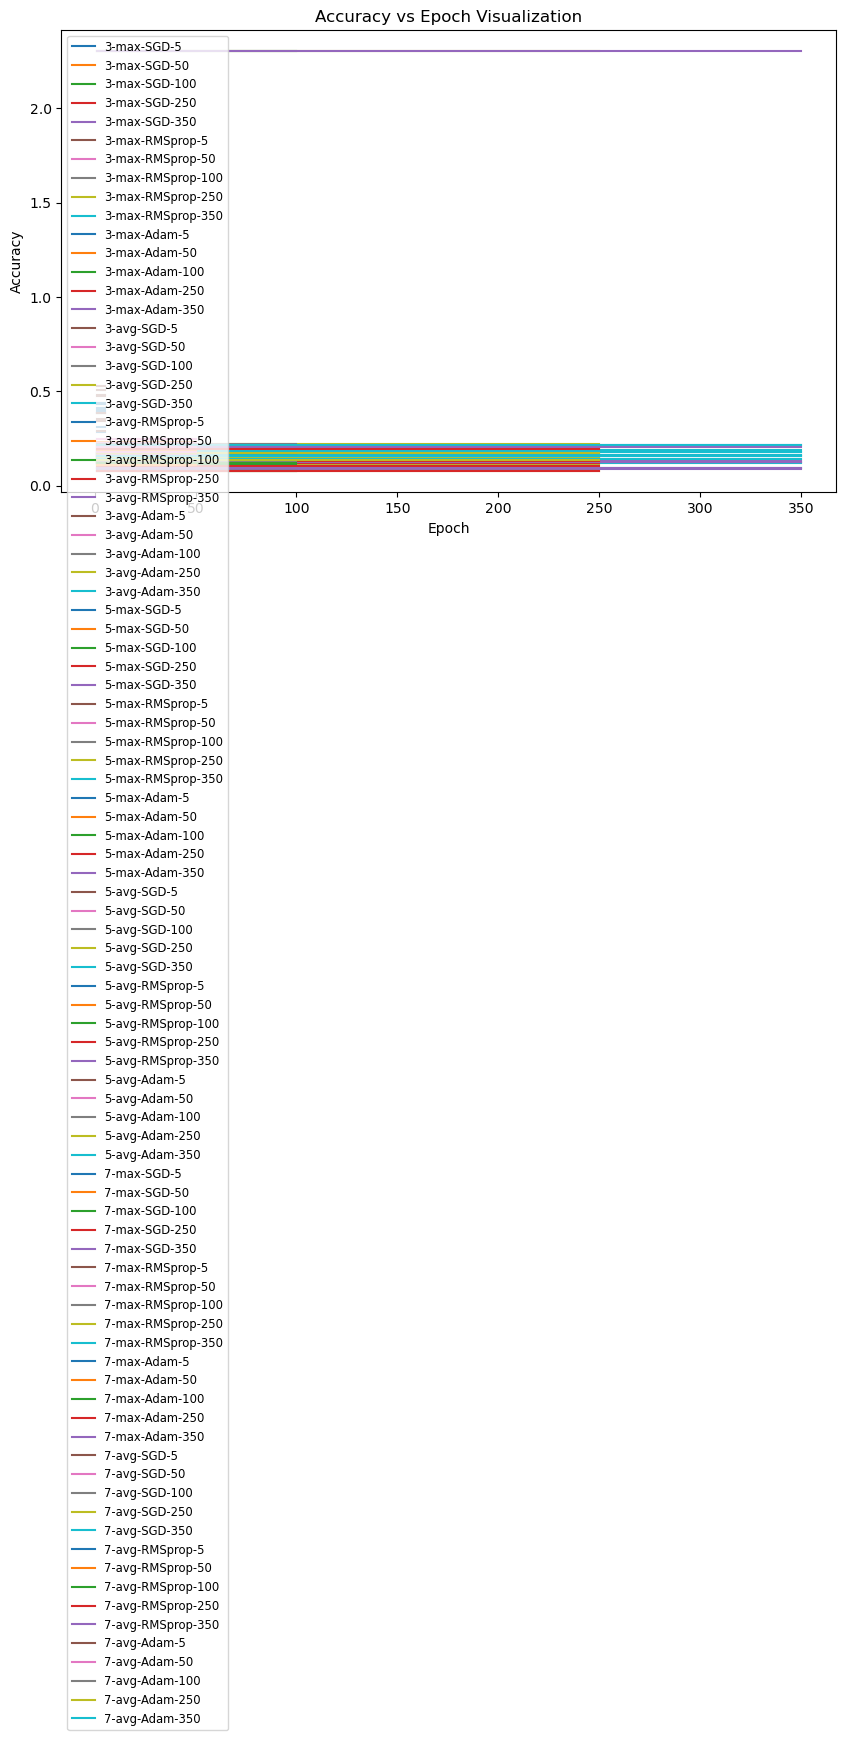

In [ ]:
# Plot Accuracy vs Epoch for Final Visualization
plt.figure(figsize=(10, 6))
for idx, (kernel, pooling, optimizer_name, epochs, train_loss, val_loss) in enumerate(final_results):
    plt.plot(range(1, int(epochs) + 1), [train_loss] * int(epochs), label=f"{kernel}-{pooling}-{optimizer_name}-{epochs}")
plt.title("Accuracy vs Epoch Visualization")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(loc="upper left", fontsize="small")
plt.savefig("Task12CNN/accuracy_vs_epoch_visualization.png")
plt.show()

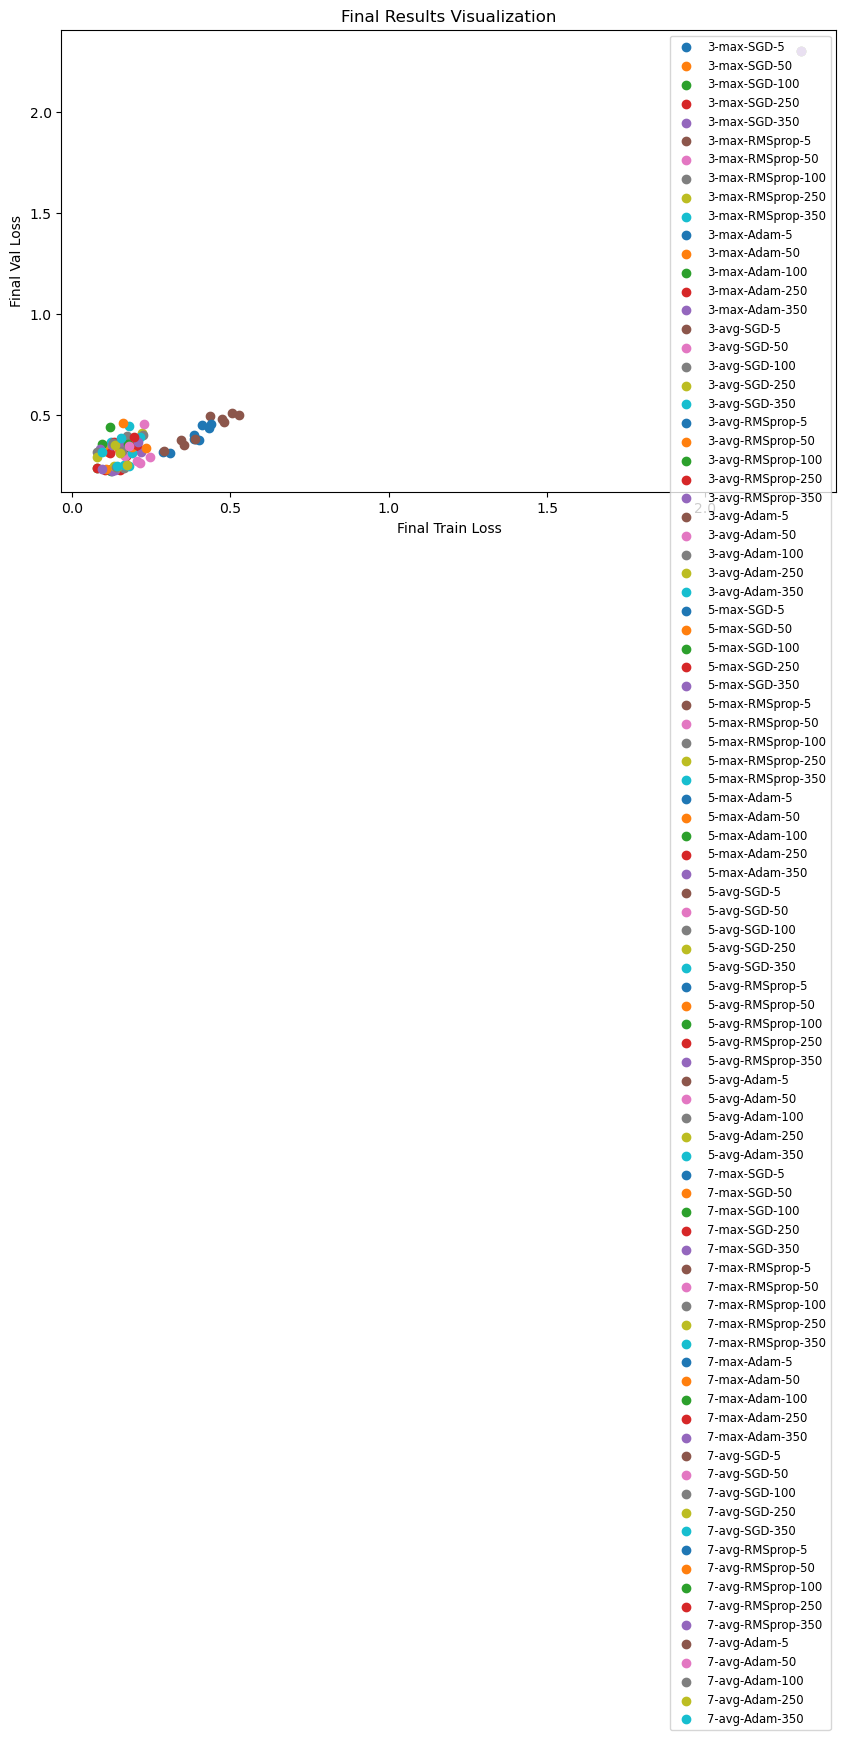

In [ ]:
# Visualisasi hasil akhir
results_array = np.array(final_results)
kernels_labels = results_array[:, 0]
poolings_labels = results_array[:, 1]
optimizers_labels = results_array[:, 2]
epochs_labels = results_array[:, 3]
final_train_losses = results_array[:, 4].astype(float)
final_val_losses = results_array[:, 5].astype(float)

fig, ax = plt.subplots(figsize=(10, 6))
for idx, (train_loss, val_loss) in enumerate(zip(final_train_losses, final_val_losses)):
    ax.scatter(train_loss, val_loss, label=f"{kernels_labels[idx]}-{poolings_labels[idx]}-{optimizers_labels[idx]}-{epochs_labels[idx]}")

ax.set_xlabel("Final Train Loss")
ax.set_ylabel("Final Val Loss")
ax.set_title("Final Results Visualization")
ax.legend(loc='upper right', fontsize='small')

# Menyimpan visualisasi scatter plot
plt.savefig("Task12CNN/final_results_visualization.png")
plt.show()